# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import nimfa
from functions.utils import *
from functions.plotting import *

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False

## Import data

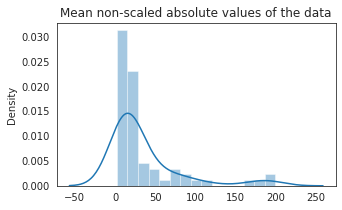

In [2]:
fc = pd.read_csv('/uftp/users/ashchetsova/hackathon/data_90_day.tsv', index_col=0,sep='\t')
anno = pd.read_csv('/uftp/users/ashchetsova/hackathon/total_annotation.tsv', index_col=0,sep='\t')
anno.index = anno.Sample_ID
anno = anno[['ID','cGVHD_development_time', 'cGVHD_development', 'Days','Day_after_transplant']]
anno = anno[~anno.index.duplicated()]
durations = pd.concat([anno[anno.cGVHD_development_time.isna()].ID.map(lambda x:anno[anno.ID==x].Day_after_transplant.max()),anno[~anno.cGVHD_development_time.isna()].cGVHD_development_time
                      ])
events = fc.GVHD_status
durations = durations.reindex(events.index).clip(90,370)-90

fc = fc.drop(columns = ['patient', 'day', 'GVHD_status',
       'GVHD_day'])

fig,ax=plt.subplots(figsize=(5,3))
sns.distplot(fc.T.mean(),ax=ax)
plt.title('Mean non-scaled absolute values of the data')
plt.savefig('plots/eda_distplot_non_scaled.png',dpi=300, bbox_inches='tight')

In [3]:
to_drop = ['Th22 EM maturity and None expression', # high variability or potentially below lod
 'Th17.1 NV maturity and None expression',
 'Th22 CM maturity and None expression',
 'Th17 TE maturity and None expression',
 'Th1 EM maturity and None expression',
 'Th17.1 CM maturity and None expression',
 'CD8+ EMTM maturity and PD-1-TIGIT- expression',
 'Th17.1 TE maturity and None expression',
 'CD8+ EMTM maturity and PD-1-TIGIT+ expression',
 'Treg_Th1 None maturity and None expression',
 'CD8+ EMTM maturity and PD1+ expression',
 'Treg_Th17.1 None maturity and None expression',
 'Th17 EM maturity and None expression',
 'CD8+ EM maturity and None expression',
 'Treg None maturity and CD226+TIGIT- expression',
 'Th22 TE maturity and None expression',
 'Th17.1 EM maturity and None expression',
 'CD8+ EMTM maturity and CD39+ expression',
 'Th22 NV maturity and None expression',
 'Th17 NV maturity and None expression',
 'CD4+ EM maturity and None expression',
 'CD8+ EMTM maturity and PD-1+TIGIT+ expression','Th2 TE maturity and None expression', 'Th2 EM maturity and None expression']+['CD4+ EMTM maturity and None expression',# potentially dupes
 'CD8+ EMTM maturity and None expression',
 'CD4+ EM maturity and TIGIT+ expression',
 'CD8+ CM maturity and PD1+ expression',
 'CD4+ None maturity and TIGIT+ expression',
 'CD8+ None maturity and PD-1-TIGIT+ expression',
 'Treg None maturity and CD226+ expression',
 'CD4+ CM maturity and TIGIT+ expression']

fc = fc.drop(columns = to_drop)

## Feature engineering

In [14]:
populations_united = {'active_t_cells':fc.columns[fc.columns.str.match('.*CD226\+(?!.*TIGIT\+).*')].to_list()+fc.columns[fc.columns.str.match('.*HLA-DR\+.*')].to_list(), 
                     'supressed_t_cells':fc.columns[fc.columns.str.match('.*CD39\+')].to_list()+fc.columns[fc.columns.str.match('.*PD1\+')].to_list()+fc.columns[fc.columns.str.match('.*TIGIT\+(?!.*CD226\+)')].to_list(),
                      'cd4_t_cells':fc.columns[fc.columns.str.match('CD4\+')].to_list(),
                      'cd8_t_cells':fc.columns[fc.columns.str.match('CD8\+.*')].to_list(),
                      'th1':fc.columns[fc.columns.str.match('Th1(?!.*Th17\+).*')].to_list()
                     }

populations_united = {i: GeneSet(i,'',populations_united[i]) for i in populations_united.keys()}

In [15]:
populations_united = ssgsea_formula(fc, populations_united)
populations_united.head()

active_t_cells  supressed_t_cells  cd4_t_cells  cd8_t_cells        th1
48_90       34.720825          20.834527    31.616446    37.917927   5.312467
53_90       34.622410          26.407950    30.977013    40.094525  -3.880803
52_90       32.522661          27.688931    30.927245    40.977506  -0.678000
60_90       31.192386          30.589350    38.489714    36.022779 -23.943320
1_90        35.117313          27.758291    42.452618    25.253452  -6.055629

In [16]:
populations_united['active_to_suppressed_t_cells'] = populations_united.active_t_cells/populations_united.supressed_t_cells
populations_united['cd4_to_cd8_t_cells'] = populations_united.cd4_t_cells/populations_united.cd4_t_cells/populations_united.cd8_t_cells
populations_united['th1_to_cd4_t_cells'] = populations_united.th1/populations_united.cd4_t_cells

populations_united.head()

active_t_cells  supressed_t_cells  cd4_t_cells  cd8_t_cells        th1  \
48_90       34.720825          20.834527    31.616446    37.917927   5.312467   
53_90       34.622410          26.407950    30.977013    40.094525  -3.880803   
52_90       32.522661          27.688931    30.927245    40.977506  -0.678000   
60_90       31.192386          30.589350    38.489714    36.022779 -23.943320   
1_90        35.117313          27.758291    42.452618    25.253452  -6.055629   

       active_to_suppressed_t_cells  cd4_to_cd8_t_cells  th1_to_cd4_t_cells  
48_90                      1.666504            0.026373            0.168029  
53_90                      1.311060            0.024941           -0.125280  
52_90                      1.174573            0.024404           -0.021922  
60_90                      1.019714            0.027760           -0.622071  
1_90                       1.265111            0.039599           -0.142644

In [17]:
populations_united = median_scale(populations_united).clip(-4,4)

## NMF Clusters

In [18]:
clusters = read_dataset('NMF_results/patient_clustering.tsv')['patient_cluster']

# KME

In [19]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [63]:
ps = {}
for col in populations_united.columns:
    feature = pd.qcut(populations_united[col],q=[0,0.5,1], labels=[f"{col},\nLower than median",f"{col},\nHigher than median"])
    locker_low = feature[feature==[i for i in feature.unique() if 'Lower' in i][0]].index
    locker_high = feature[feature==[i for i in feature.unique() if 'Higher' in i][0]].index
    lr = logrank_test(durations.loc[locker_low], durations.loc[locker_high], event_observed_A=events.loc[locker_low], event_observed_B=events.loc[locker_high], ) 
    ps[col] = lr.p_value
for col in fc.columns:
    feature = pd.qcut(fc[col],q=[0,0.5,1], labels=[f"{col},\nLower than median",f"{col},\nHigher than median"])
    locker_low = feature[feature==[i for i in feature.unique() if 'Lower' in i][0]].index
    locker_high = feature[feature==[i for i in feature.unique() if 'Higher' in i][0]].index
    lr = logrank_test(durations.loc[locker_low], durations.loc[locker_high], event_observed_A=events.loc[locker_low], event_observed_B=events.loc[locker_high], ) 
    ps[col] = lr.p_value

feature = clusters
locker_low = feature[feature==[i for i in feature.unique() if 'Th1 TE' in i][0]].index
locker_high = feature[feature==[i for i in feature.unique() if 'T helpers Naiv' in i][0]].index
lr = logrank_test(durations.loc[locker_low], durations.loc[locker_high], event_observed_A=events.loc[locker_low], event_observed_B=events.loc[locker_high], ) 

ps['NMF_Clusters'] = lr.p_value

In [64]:
from statsmodels.stats.multitest import multipletests
ps = pd.Series(ps)
_, fdr, _, _ = multipletests(ps, method='fdr_bh')

In [65]:
fdr = pd.Series(index=list(ps.keys()), data = fdr)

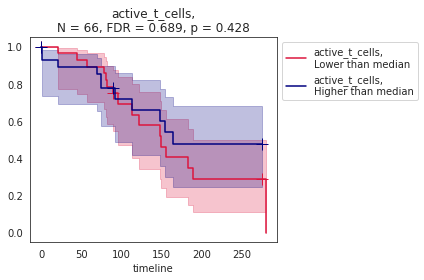

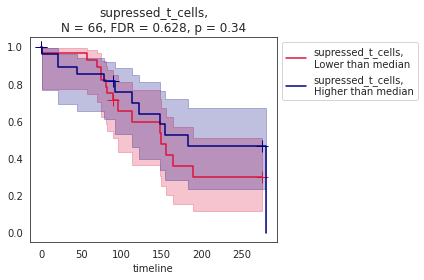

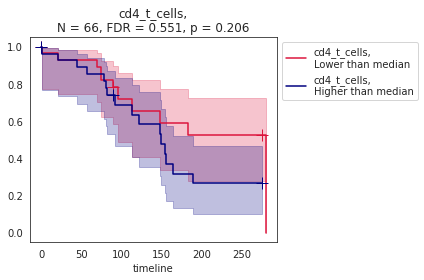

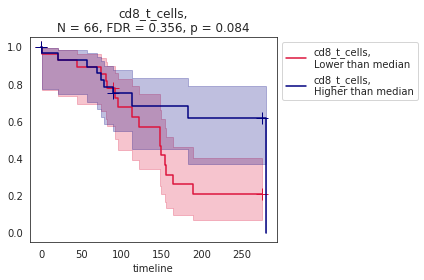

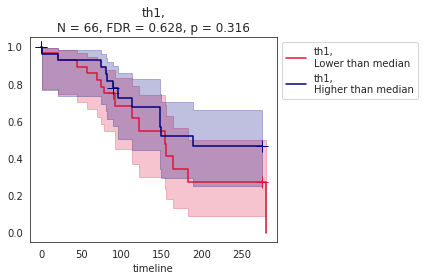

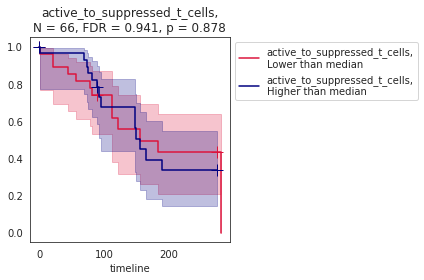

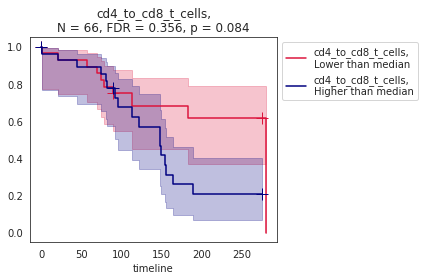

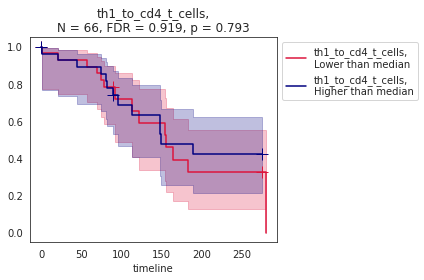

In [66]:
for col in populations_united.columns:
    fig,axes = plt.subplots(1,1, figsize=(6,4))
    kmf = KaplanMeierFitter()
    feature = pd.qcut(populations_united[col],q=[0,0.5,1], labels=[f"{col},\nLower than median",f"{col},\nHigher than median"])
    locker_low = feature[feature==[i for i in feature.unique() if 'Lower' in i][0]].index
    kmf.fit(durations.loc[locker_low], events.loc[locker_low], label=[i for i in feature.unique() if 'Lower' in i][0])
    ax = kmf.plot(show_censors=True,color='crimson')
    locker_high = feature[feature==[i for i in feature.unique() if 'Higher' in i][0]].index
    kmf.fit(durations.loc[locker_high], events.loc[locker_high], label=[i for i in feature.unique() if 'Higher' in i][0])
    ax = kmf.plot(show_censors=True, color='navy')
    p = round(ps.loc[col],3)
    f = round(fdr.loc[col],3)
    plt.title(f"{col},\nN = {len(events)}, FDR = {f}, p = {p}")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    plt.close()

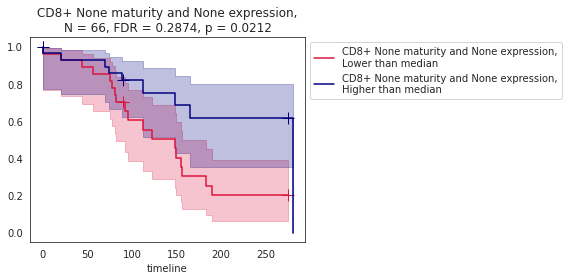

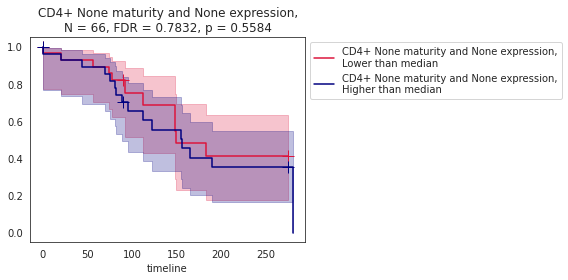

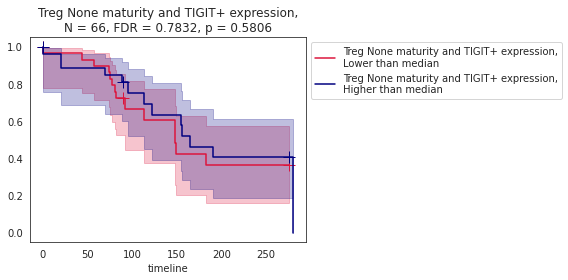

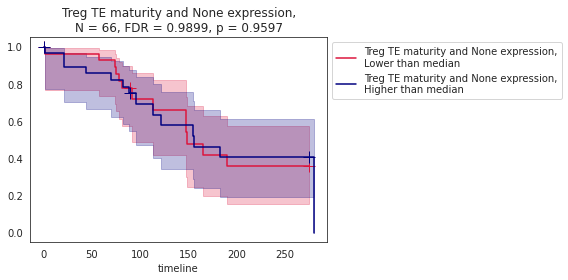

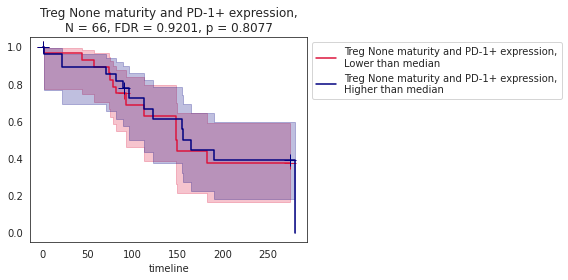

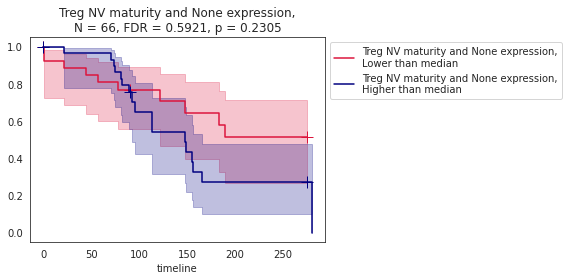

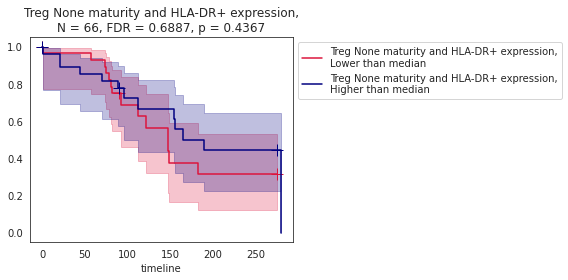

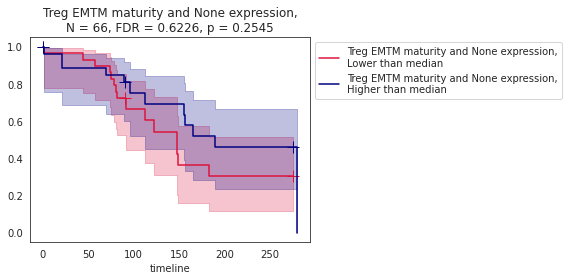

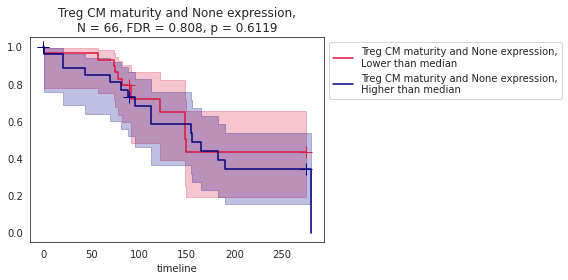

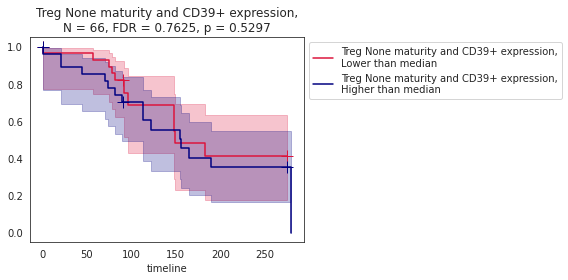

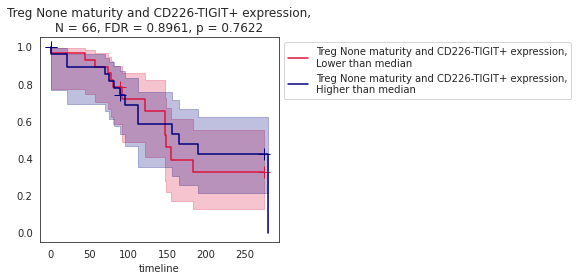

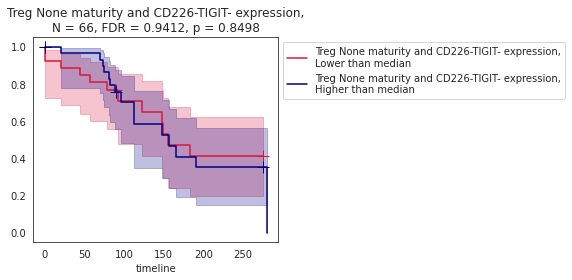

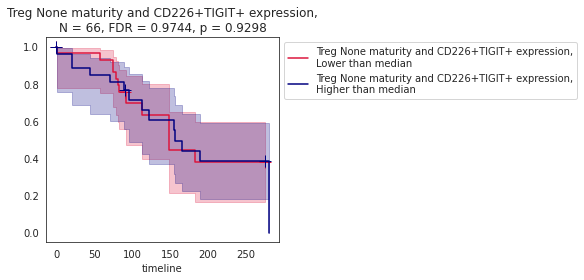

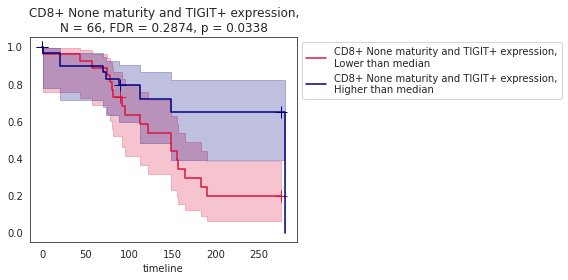

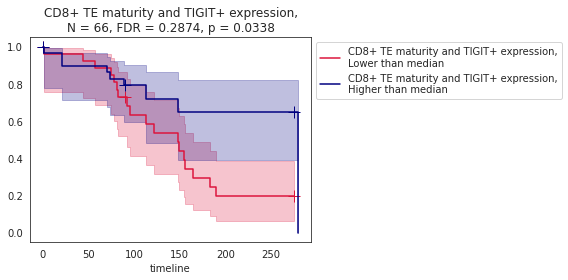

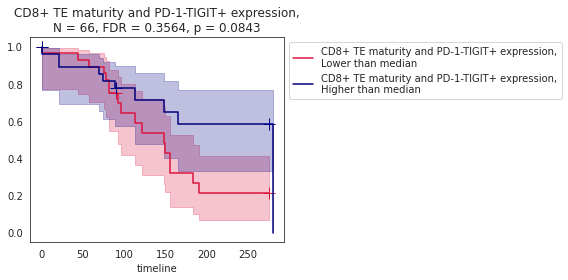

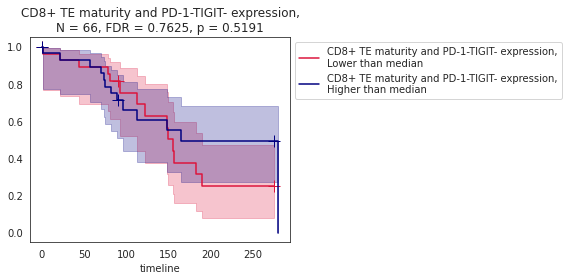

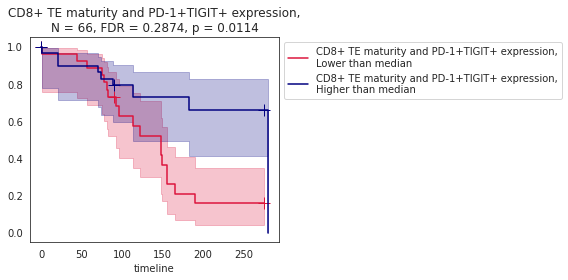

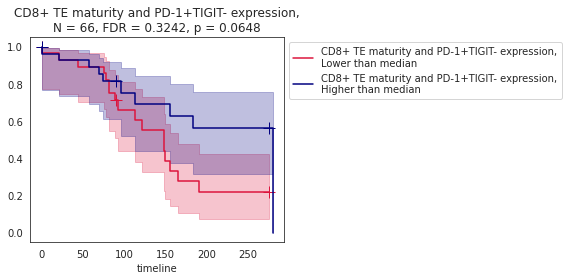

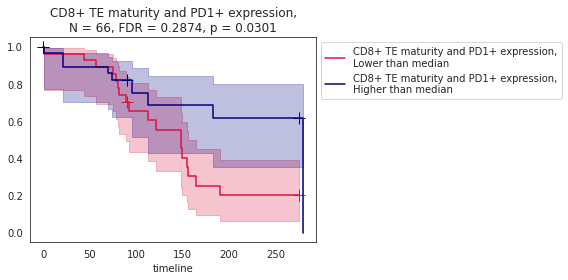

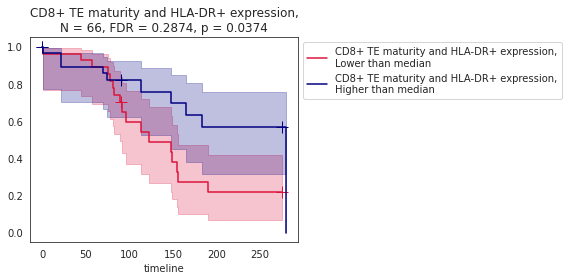

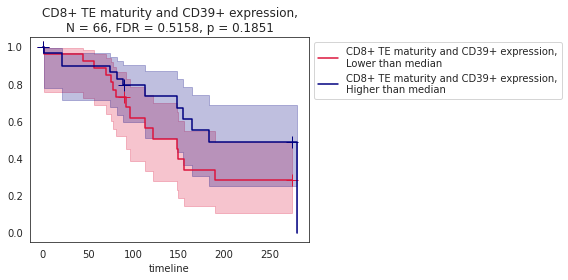

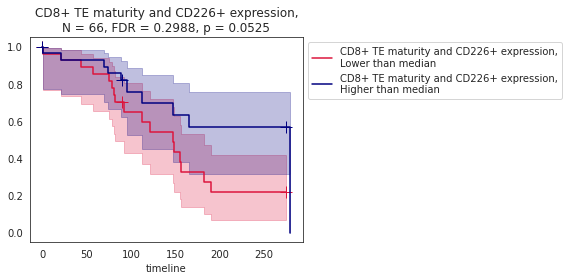

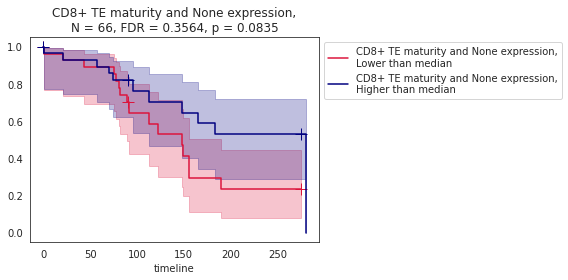

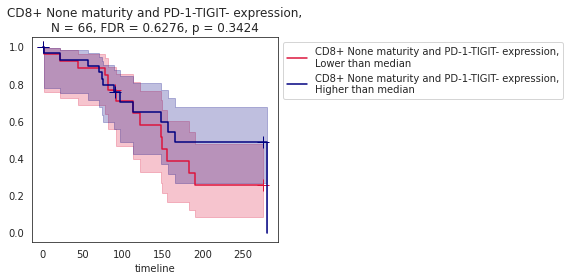

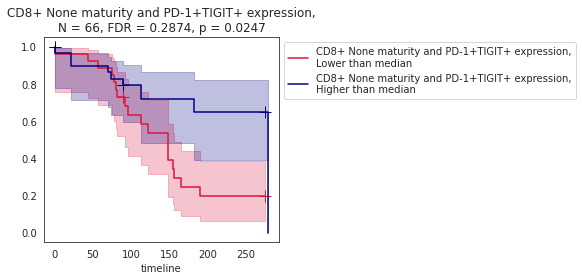

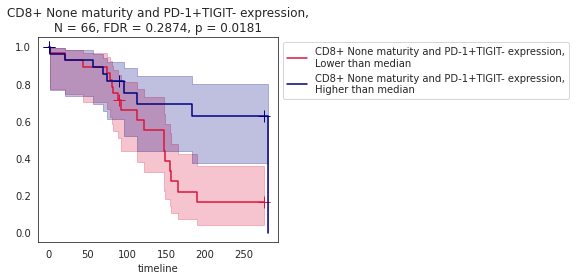

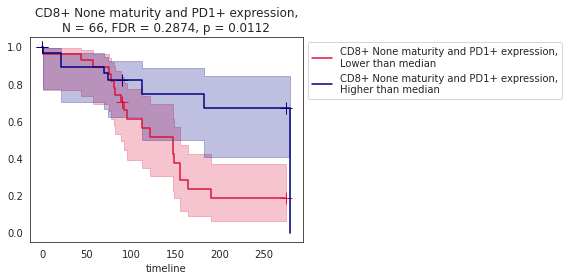

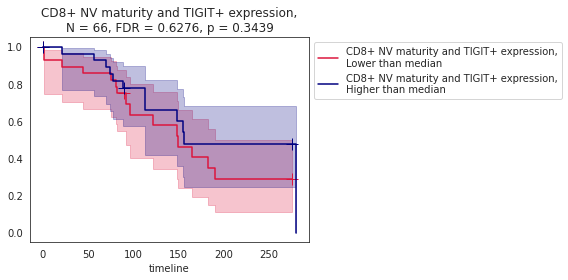

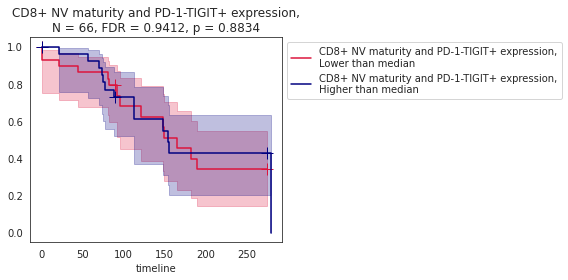

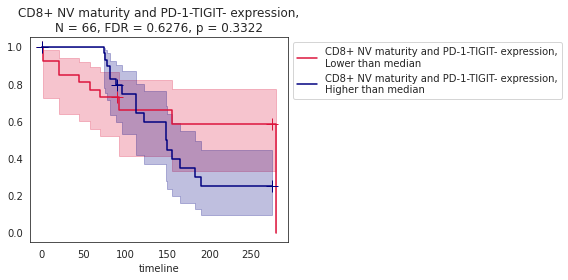

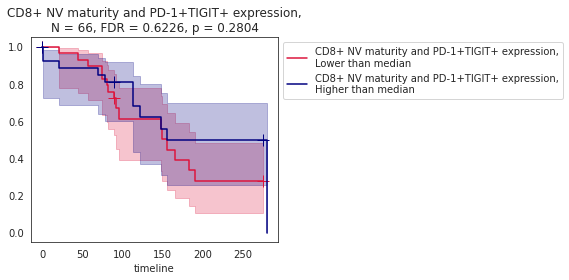

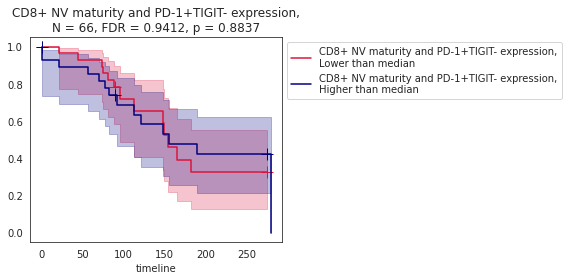

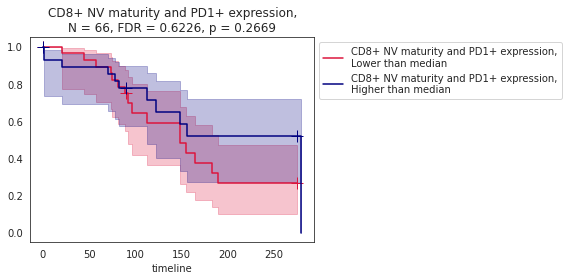

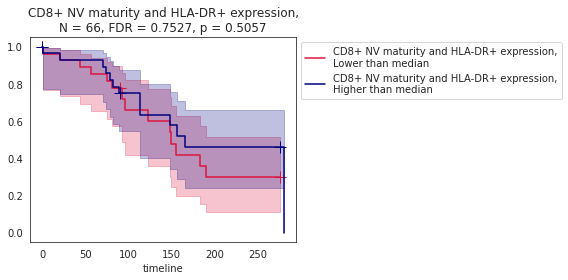

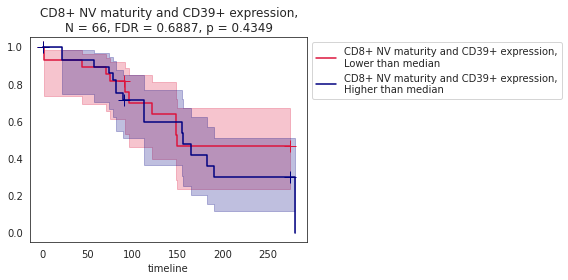

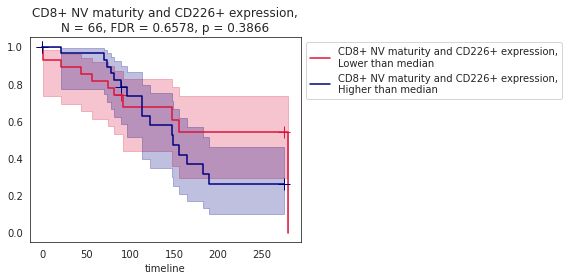

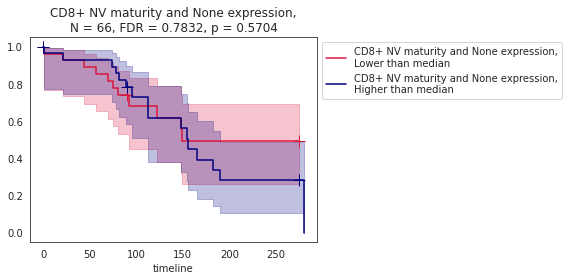

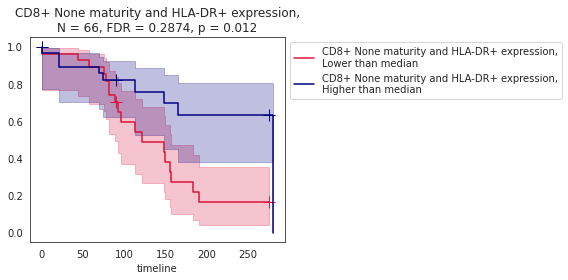

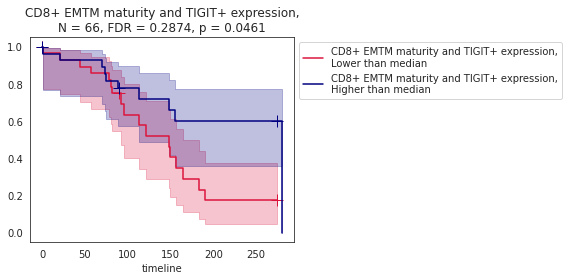

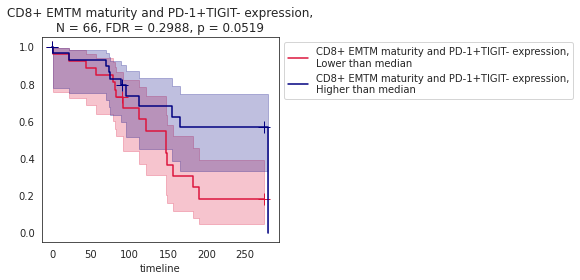

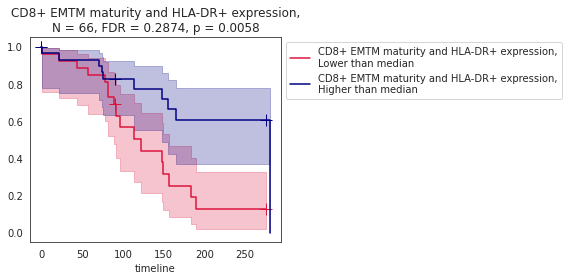

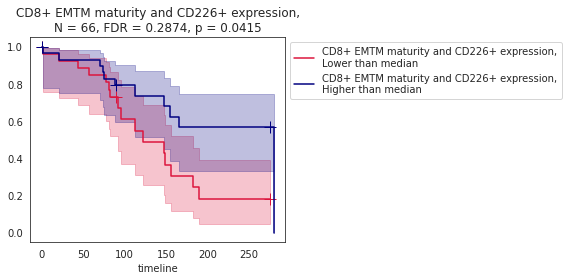

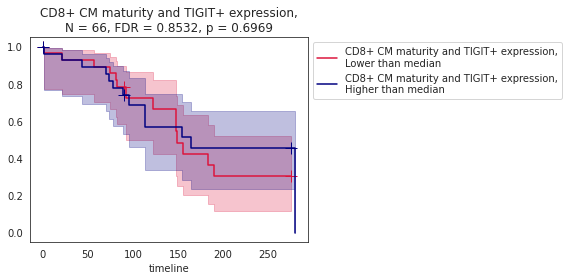

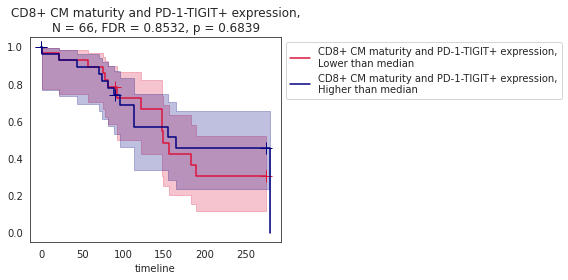

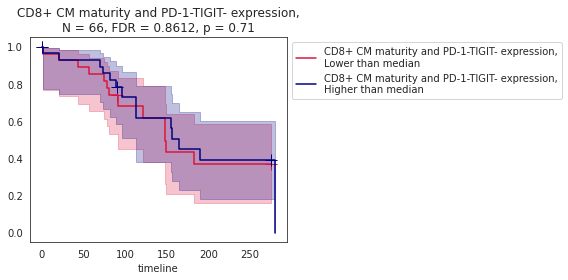

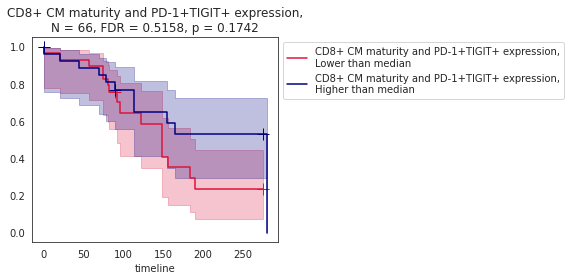

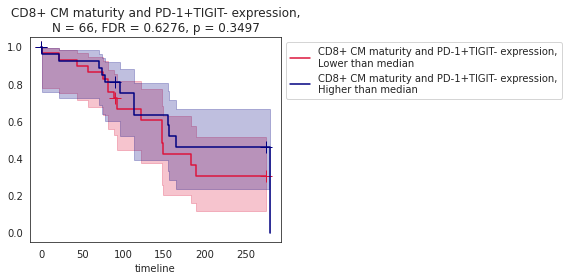

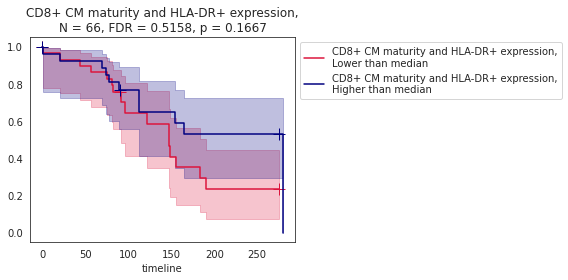

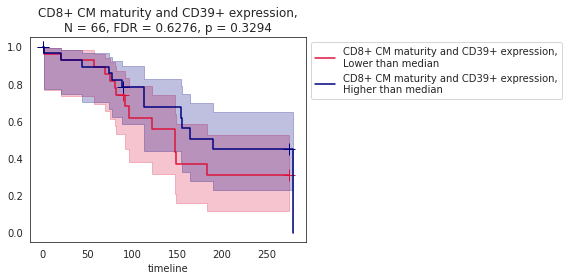

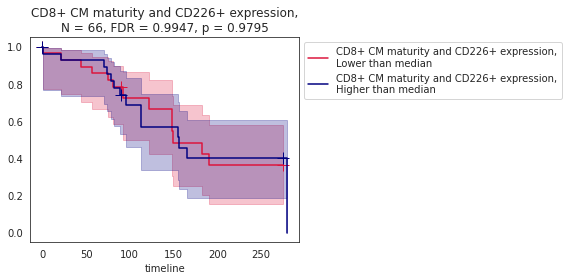

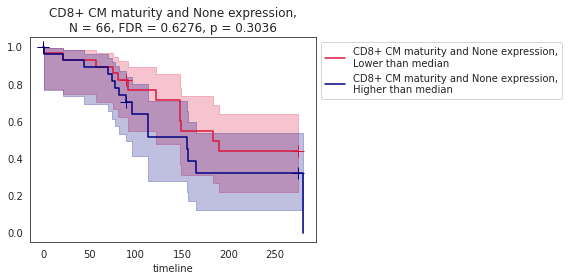

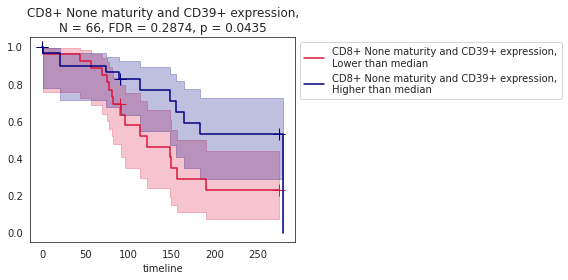

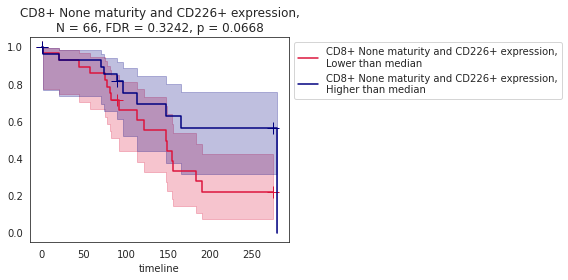

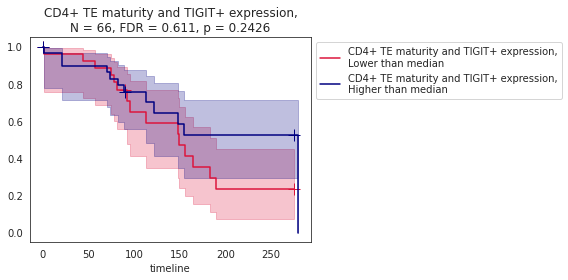

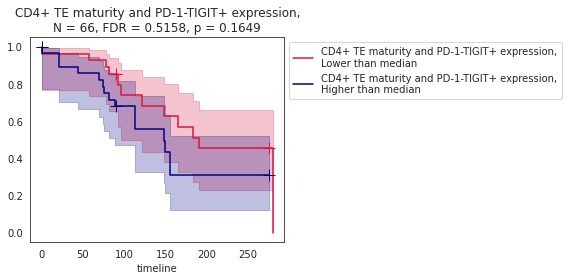

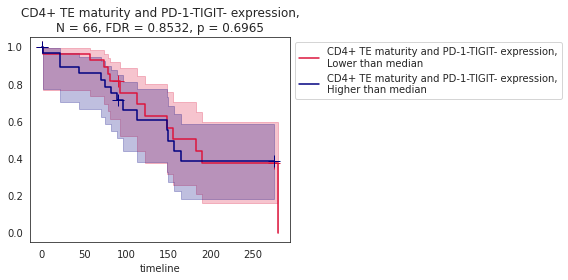

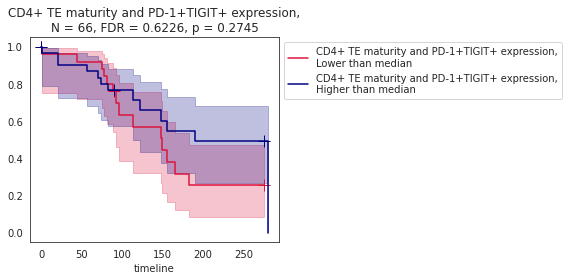

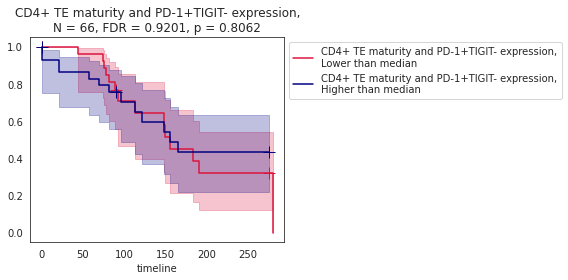

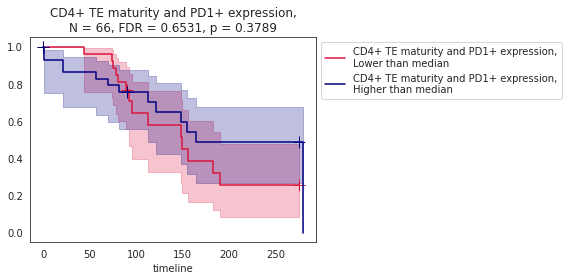

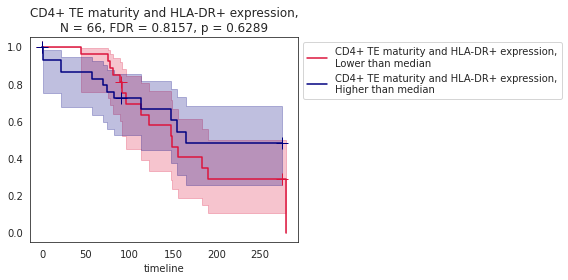

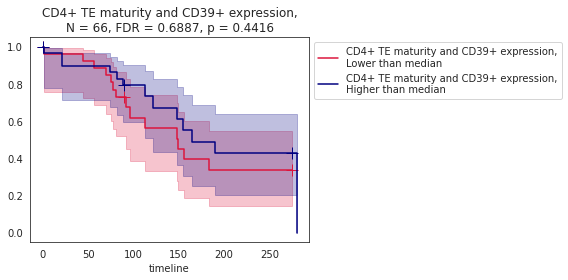

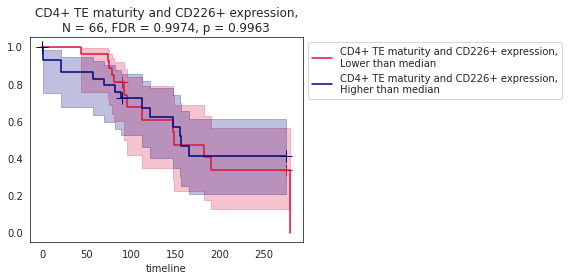

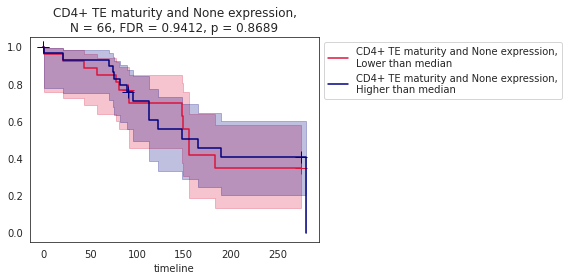

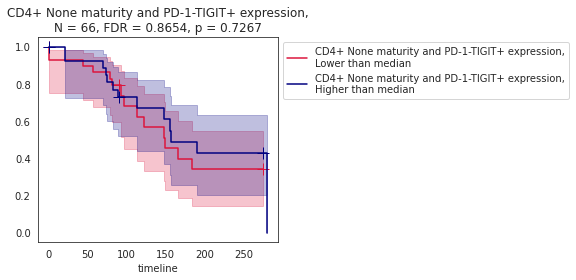

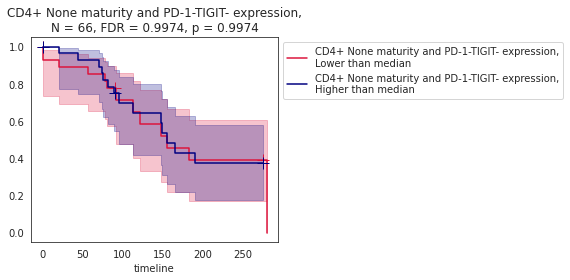

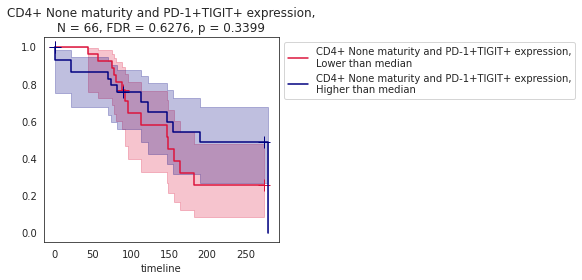

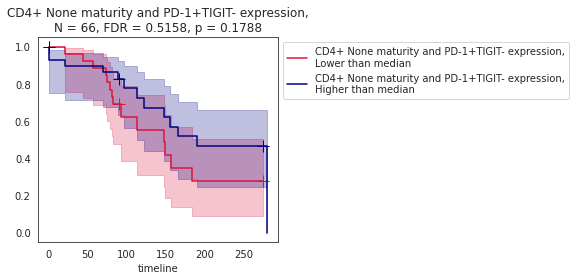

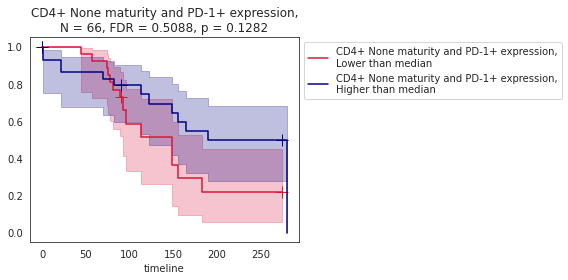

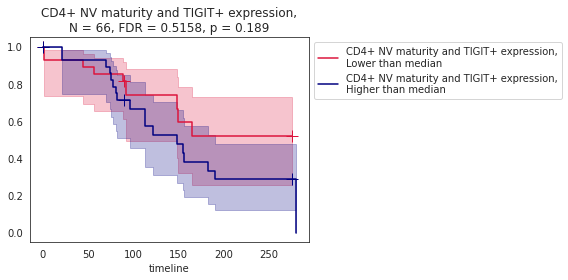

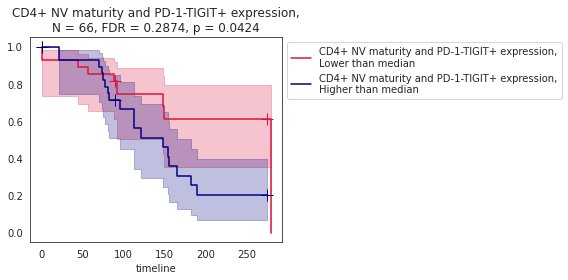

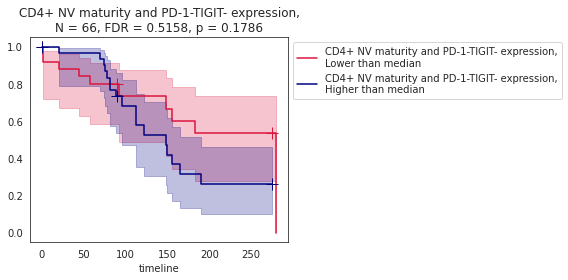

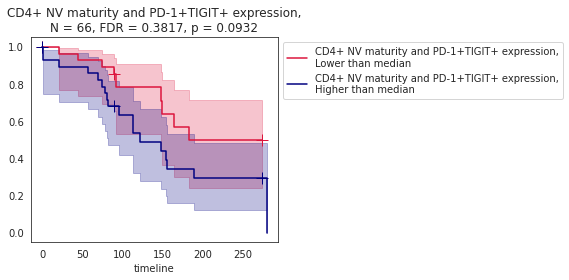

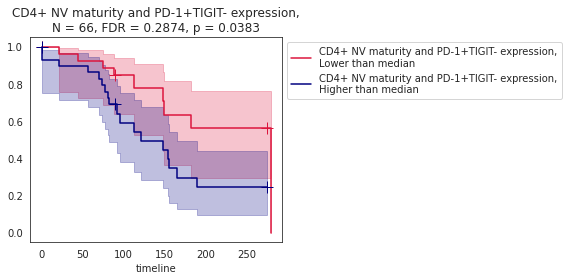

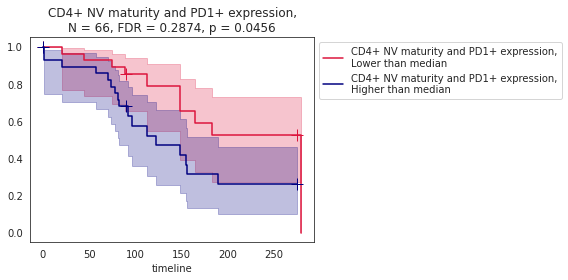

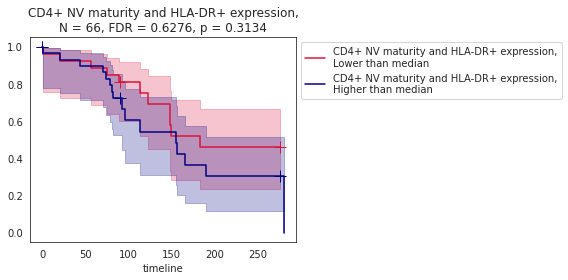

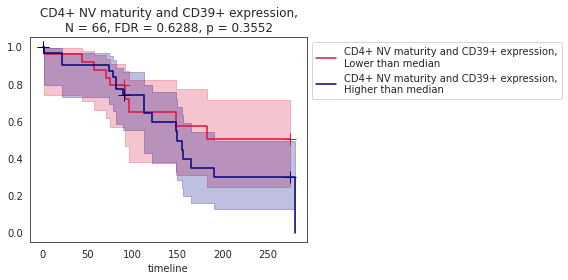

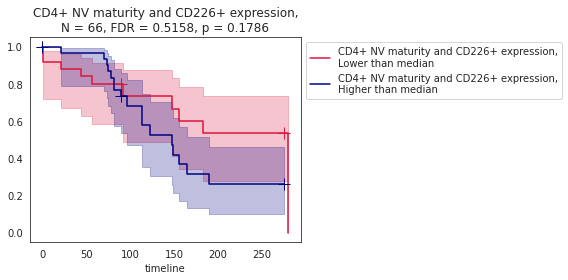

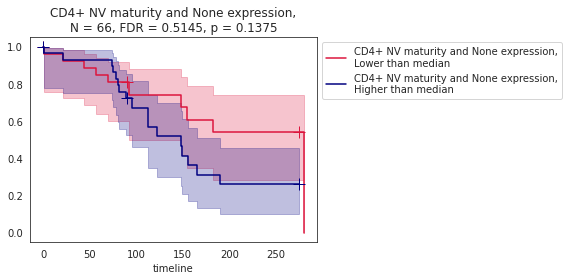

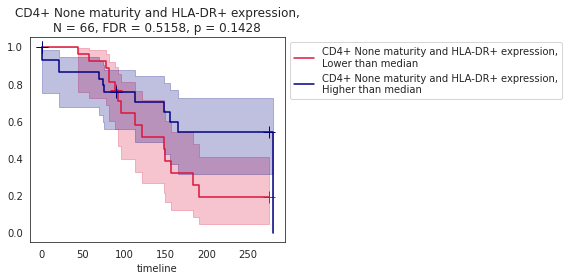

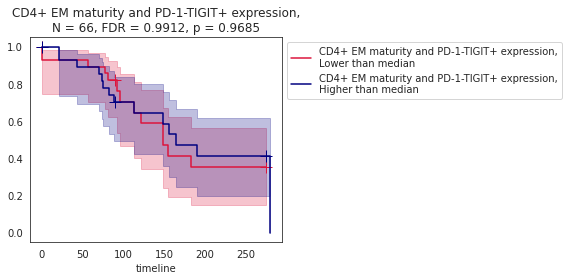

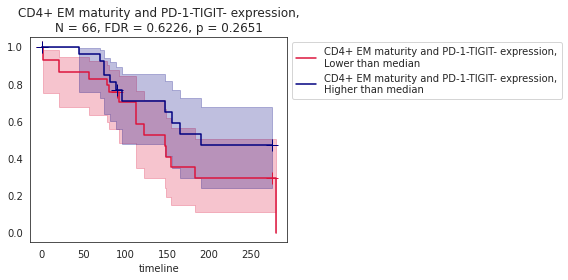

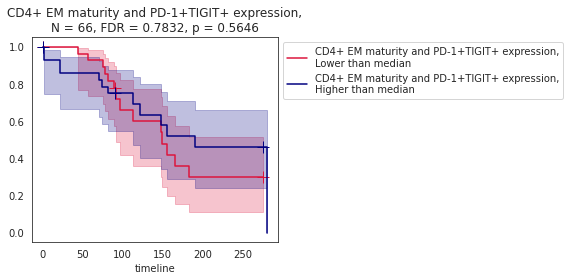

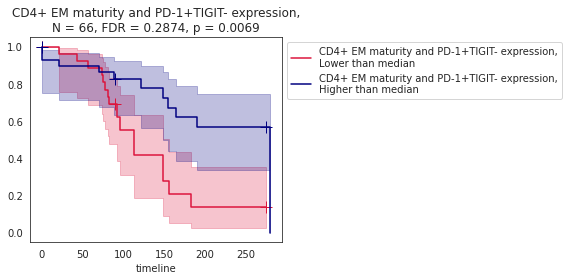

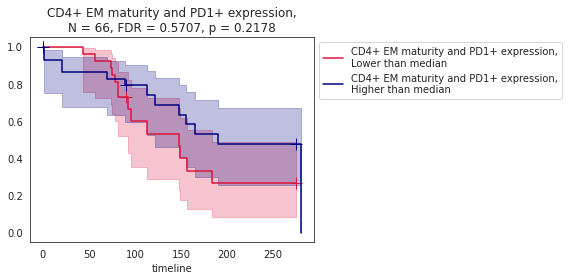

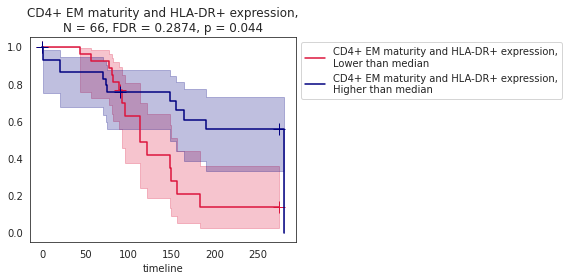

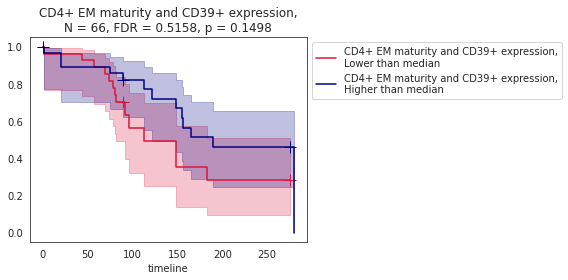

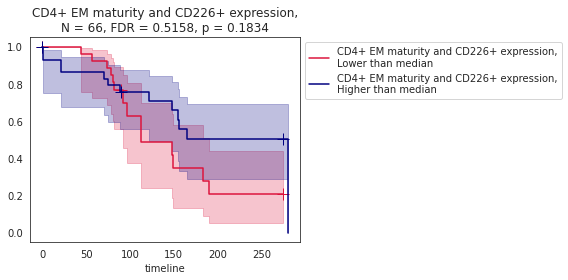

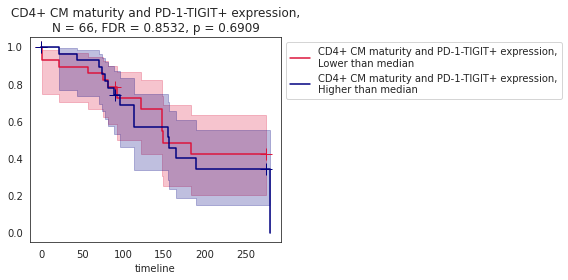

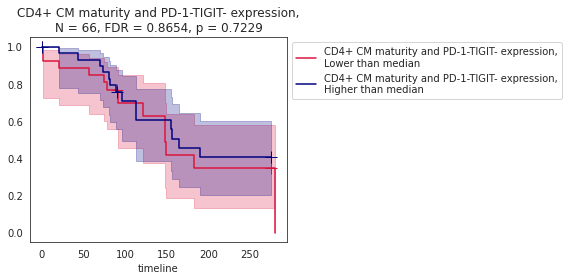

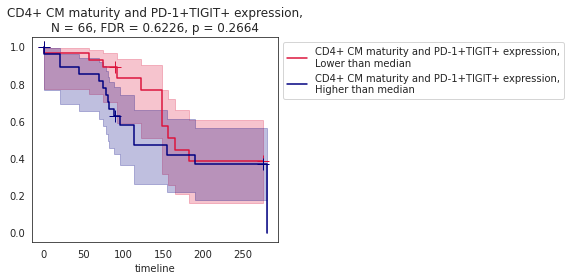

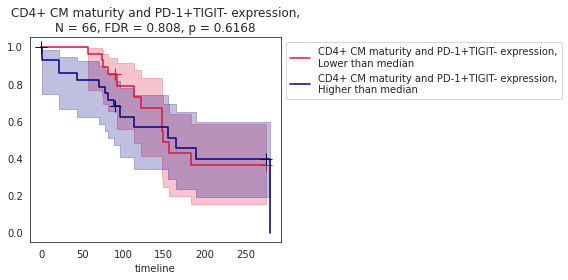

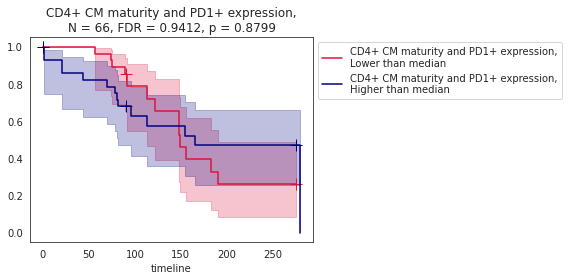

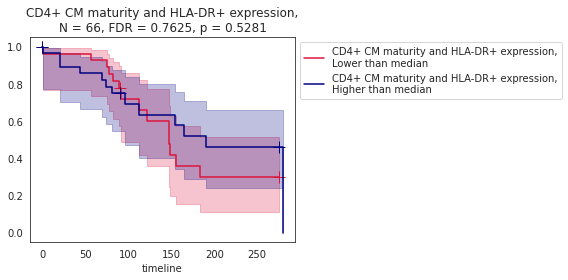

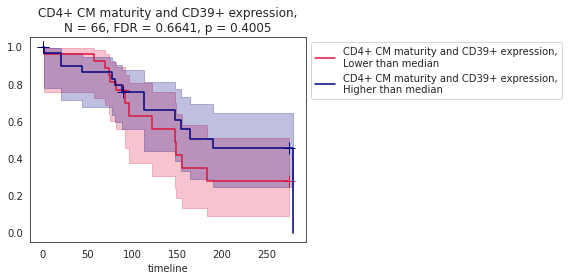

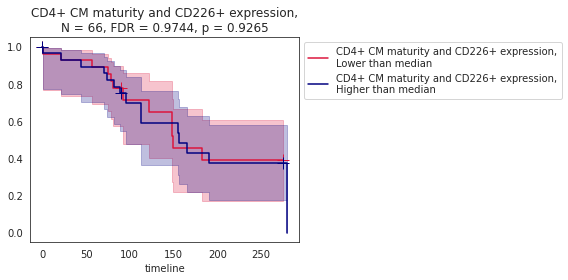

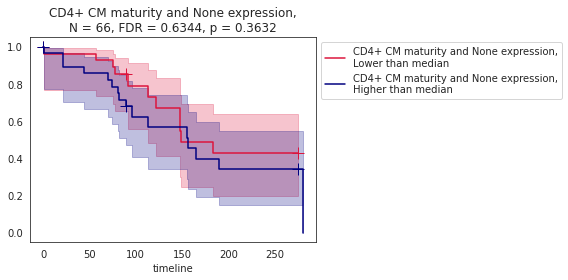

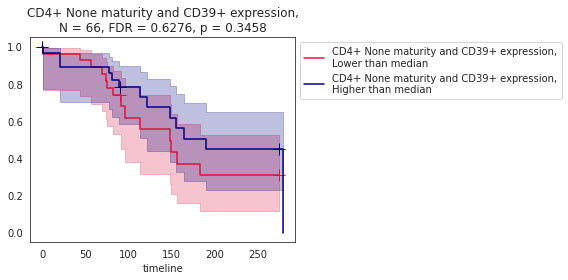

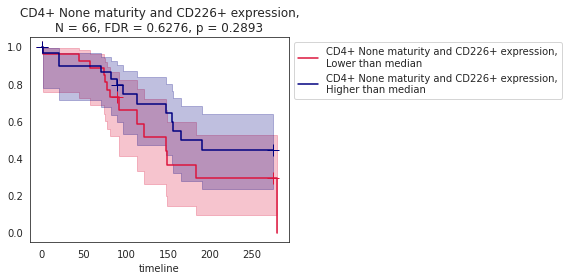

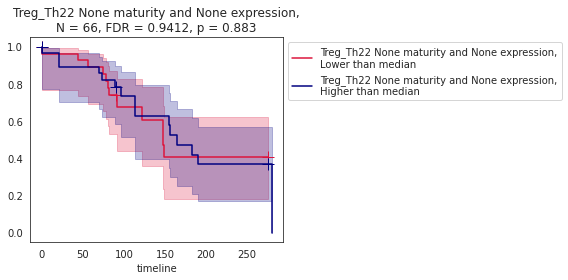

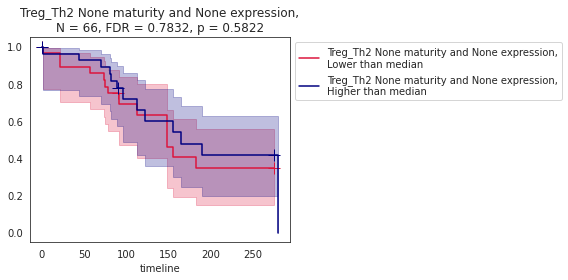

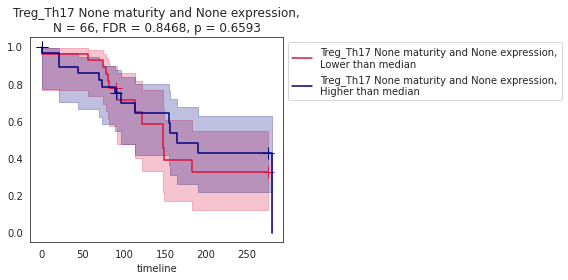

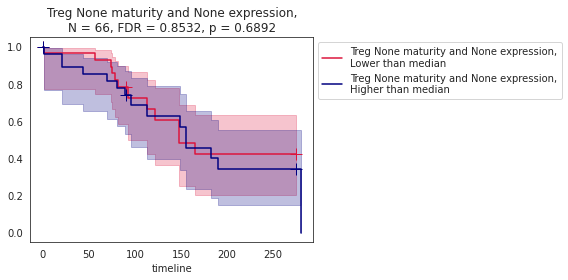

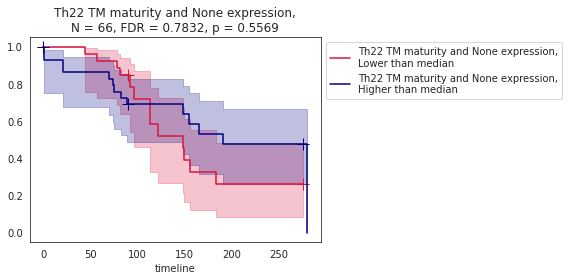

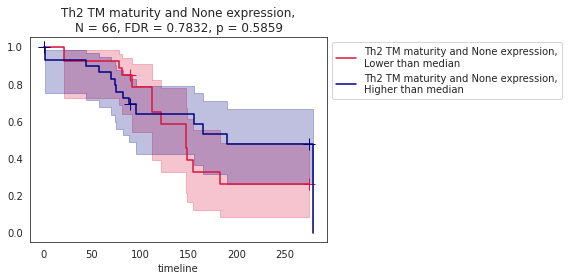

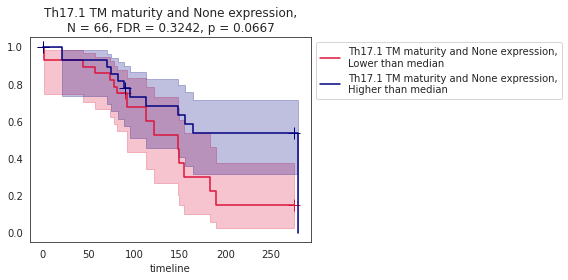

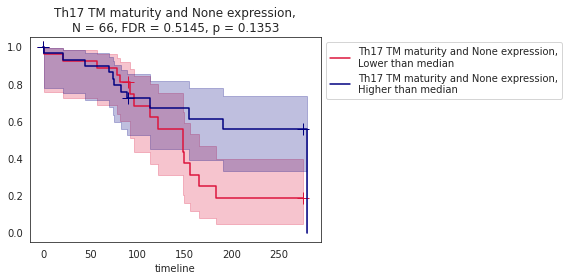

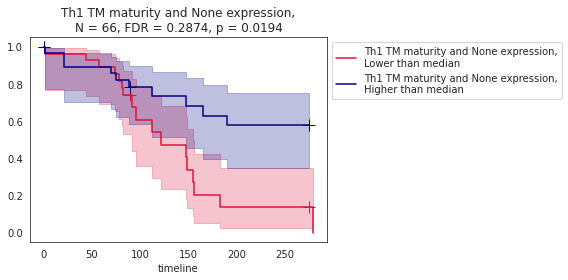

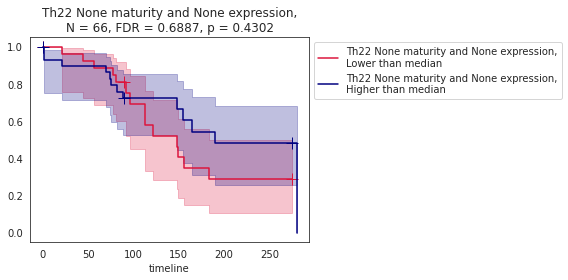

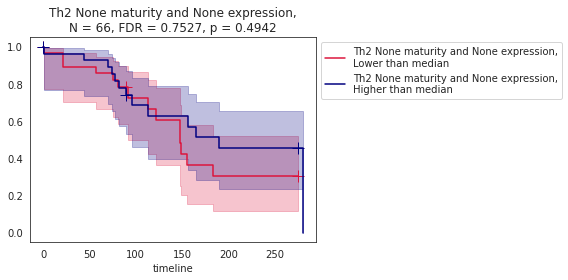

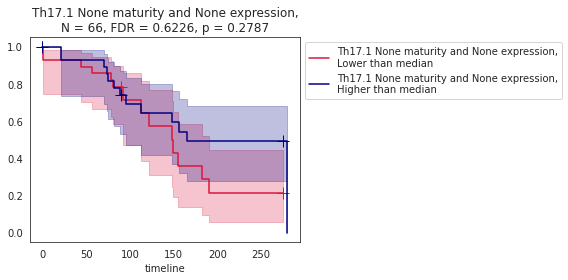

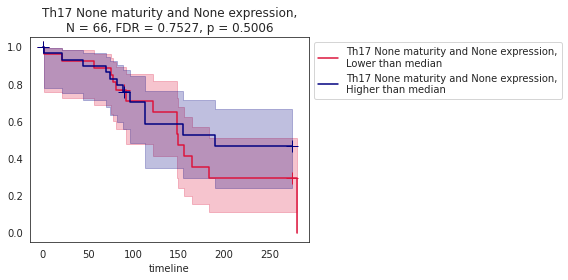

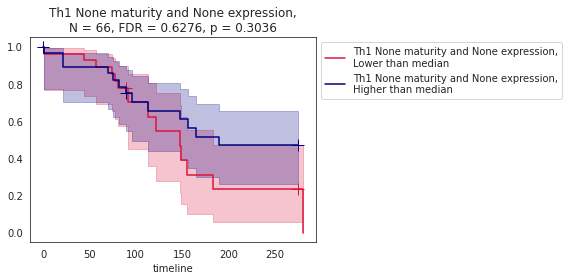

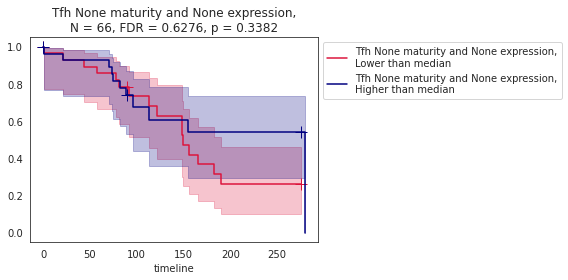

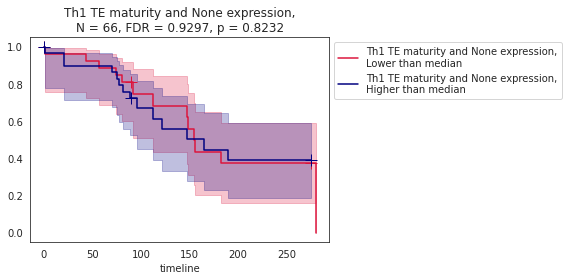

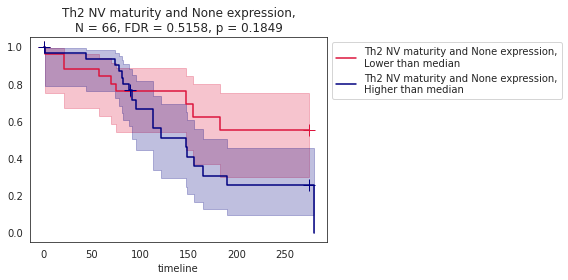

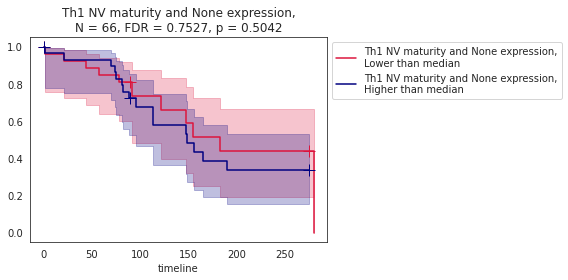

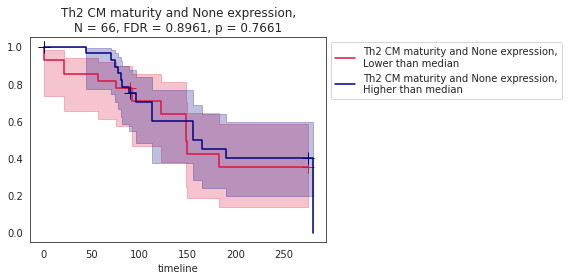

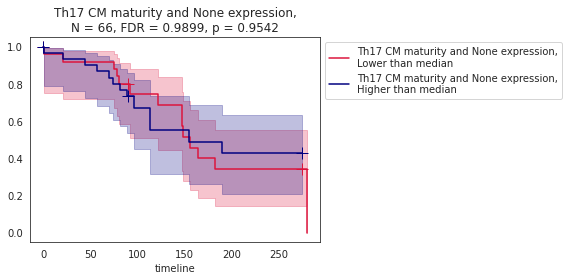

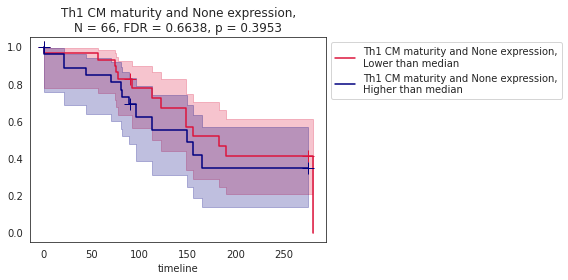

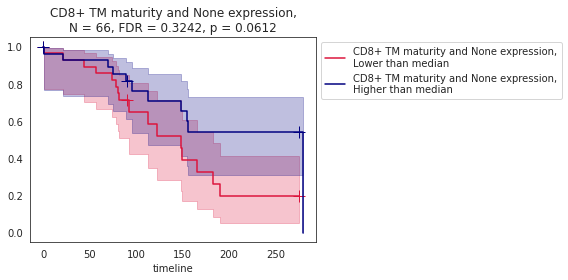

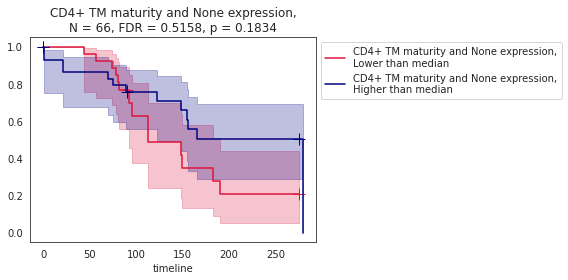

In [67]:
for col in fc.columns:
    fig,axes = plt.subplots(1,1, figsize=(8,4))
    kmf = KaplanMeierFitter()
    feature = pd.qcut(fc[col],q=[0,0.5,1], labels=[f"{col},\nLower than median",f"{col},\nHigher than median"])
    locker_low = feature[feature==[i for i in feature.unique() if 'Lower' in i][0]].index
    kmf.fit(durations.loc[locker_low], events.loc[locker_low], label=[i for i in feature.unique() if 'Lower' in i][0])
    ax = kmf.plot(show_censors=True,color='crimson')
    locker_high = feature[feature==[i for i in feature.unique() if 'Higher' in i][0]].index
    kmf.fit(durations.loc[locker_high], events.loc[locker_high], label=[i for i in feature.unique() if 'Higher' in i][0])
    ax = kmf.plot(show_censors=True, color='navy')
    p = round(ps.loc[col],4)
    f = round(fdr.loc[col],4)
    plt.title(f"{col},\nN = {len(events)}, FDR = {f}, p = {p}")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    plt.close()

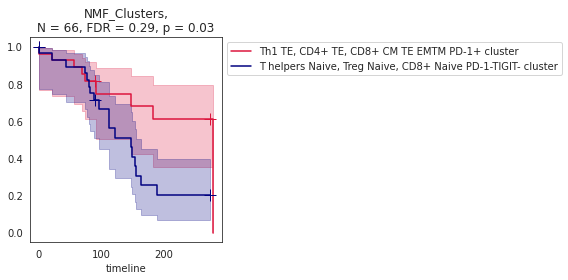

In [68]:
col = 'NMF_Clusters'
fig,axes = plt.subplots(1,1, figsize=(8,4))
kmf = KaplanMeierFitter()
feature = clusters
locker_low = feature[feature==[i for i in feature.unique() if 'Th1 TE' in i][0]].index
kmf.fit(durations.loc[locker_low], events.loc[locker_low], label=[i for i in feature.unique() if 'Th1 TE' in i][0])
ax = kmf.plot(show_censors=True,color='crimson')
locker_high = feature[feature==[i for i in feature.unique() if 'T helpers Naiv' in i][0]].index
kmf.fit(durations.loc[locker_high], events.loc[locker_high], label=[i for i in feature.unique() if 'T helpers Naiv' in i][0])
ax = kmf.plot(show_censors=True, color='navy')
p = round(ps.loc[col],2)
f = round(fdr.loc[col],2)
plt.title(f"{col},\nN = {len(events)}, FDR = {f}, p = {p}")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
plt.close()

# CPH

In [31]:
import random

In [29]:
metrics = {}
categorized = []
from lifelines import CoxPHFitter
def count_uni_cox(metric, cel):
    drop=False
    cox = CoxPHFitter()
    metric, _ = to_common_samples((metric.dropna(), durations))
    data = pd.DataFrame(data=metric,index=metric.index, columns = [metric.name])
    data['duration'], data['events'] = durations, events
    cox.fit(data,'duration', 'events')
    a = cox.check_assumptions(data, p_value_threshold=0.05, show_plots=False, plot_n_bootstraps=15)
    if len(a)>0:
        data = pd.DataFrame(data=pd.qcut(metric,q=[0,0.5, 1],labels=['Low','High']).to_list(),index=metric.index, columns = [metric.name])
        data['duration'], data['events'] = sd.duration, sd.events
        data = pd.concat([data,pd.get_dummies(data[metric.name])],axis=1)
        data = data.drop(columns = ['Low',metric.name])
        data.columns = [f"{metric.name}_High" if 'High' in i else i for i in data.columns]
        metric.name = f"{metric.name}_High"
        cox.fit(data,'duration', 'events')
        a = cox.check_assumptions(data, p_value_threshold=0.05, show_plots=False, plot_n_bootstraps=50)
        if len(a)>0:
            drop=True
    if not drop:
        c = round(cox.concordance_index_,2)
        num_true = events.reindex(metric.index).value_counts().loc[True]
        text = f'Time to graft development for {metric.name}, {len(metric)} patients,\n{num_true} events, C={c}'
        print(text)
        c_low = cox.summary.loc[[i for i in cox.summary.index if cel in i]]['coef lower 95%'][0]
        c_up = cox.summary.loc[[i for i in cox.summary.index if cel in i]]['coef upper 95%'][0]
        coef = cox.summary.loc[[i for i in cox.summary.index if cel in i]]['coef'][0]
        p = cox.summary.loc[[i for i in cox.summary.index if cel in i]]['p'][0]
        return(coef,p,cox.concordance_index_, c_low, c_up,metric.name)
    else:
        return([np.nan]*5+[metric.name])

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic    p  -log2(p)
CD8+ None maturity and None expression km              4.50 0.03      4.88
                                       rank            7.06 0.01      6.99



1. Variable 'CD8+ None maturity and None expression' failed the non-proportional test: p-value is 0.0079.

   Advice 1: the functional form of the variable 'CD8+ None maturity and None expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and None expression' using pd.cut, and
then specify it in `strata=['CD8+ None maturity and None expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                            test_statistic      p  -log2(p)
Treg None maturity and TIGIT+ expression_permutated_7 km              6.36   0.01      6.42
                                                      rank            8.00 <0.005      7.74



1. Variable 'Treg None maturity and TIGIT+ expression_permutated_7' failed the non-proportional test: p-value is 0.0047.

   Advice 1: the functional form of the variable 'Treg None maturity and TIGIT+
expression_permutated_7' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Treg None maturity and TIGIT+ expression_permutated_7' using
pd.cut, and then specify it in `strata=['Treg None maturity and TIGIT+ expression_permutated_7',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebook

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic    p  -log2(p)
Treg TE maturity and None expression km              3.58 0.06      4.09
                                     rank            5.92 0.01      6.06



1. Variable 'Treg TE maturity and None expression' failed the non-proportional test: p-value is 0.0150.

   Advice 1: the functional form of the variable 'Treg TE maturity and None expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'Treg TE maturity and None expression' using pd.cut, and then
specify it in `strata=['Treg TE maturity and None expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic    p  -log2(p)
Treg TE maturity and None expression_permutated_4 km              2.74 0.10      3.36
                                                  rank            4.17 0.04      4.60



1. Variable 'Treg TE maturity and None expression_permutated_4' failed the non-proportional test: p-value is 0.0412.

   Advice 1: the functional form of the variable 'Treg TE maturity and None expression_permutated_4'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'Treg TE maturity and None expression_permutated_4' using
pd.cut, and then specify it in `strata=['Treg TE maturity and None expression_permutated_4', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
Treg None maturity and PD-1+ expression km              2.75 0.10      3.37
                                        rank            4.69 0.03      5.04



1. Variable 'Treg None maturity and PD-1+ expression' failed the non-proportional test: p-value is 0.0303.

   Advice 1: the functional form of the variable 'Treg None maturity and PD-1+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'Treg None maturity and PD-1+ expression' using pd.cut, and
then specify it in `strata=['Treg None maturity and PD-1+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-a

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic    p  -log2(p)
Treg CM maturity and None expression_permutated_7 km              3.87 0.05      4.35
                                                  rank            5.81 0.02      5.98



1. Variable 'Treg CM maturity and None expression_permutated_7' failed the non-proportional test: p-value is 0.0159.

   Advice 1: the functional form of the variable 'Treg CM maturity and None expression_permutated_7'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'Treg CM maturity and None expression_permutated_7' using
pd.cut, and then specify it in `strata=['Treg CM maturity and None expression_permutated_7', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                           test_statistic    p  -log2(p)
Treg None maturity and CD39+ expression_permutated_6 km              4.71 0.03      5.06
                                                     rank            6.28 0.01      6.36



1. Variable 'Treg None maturity and CD39+ expression_permutated_6' failed the non-proportional test: p-value is 0.0122.

   Advice 1: the functional form of the variable 'Treg None maturity and CD39+
expression_permutated_6' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Treg None maturity and CD39+ expression_permutated_6' using
pd.cut, and then specify it in `strata=['Treg None maturity and CD39+ expression_permutated_6',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Pr

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                  test_statistic    p  -log2(p)
Treg None maturity and CD226-TIGIT- expression_permutated_7 km              2.87 0.09      3.47
                                                            rank            3.85 0.05      4.33



1. Variable 'Treg None maturity and CD226-TIGIT- expression_permutated_7' failed the non-proportional test: p-value is 0.0497.

   Advice 1: the functional form of the variable 'Treg None maturity and CD226-TIGIT-
expression_permutated_7' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Treg None maturity and CD226-TIGIT- expression_permutated_7'
using pd.cut, and then specify it in `strata=['Treg None maturity and CD226-TIGIT-
expression_permutated_7', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                  test_statistic    p  -log2(p)
Treg None maturity and CD226+TIGIT+ expression_permutated_3 km              3.17 0.08      3.74
                                                            rank            4.44 0.04      4.83



1. Variable 'Treg None maturity and CD226+TIGIT+ expression_permutated_3' failed the non-proportional test: p-value is 0.0352.

   Advice 1: the functional form of the variable 'Treg None maturity and CD226+TIGIT+
expression_permutated_3' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Treg None maturity and CD226+TIGIT+ expression_permutated_3'
using pd.cut, and then specify it in `strata=['Treg None maturity and CD226+TIGIT+
expression_permutated_3', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                               test_statistic      p  -log2(p)
CD8+ None maturity and TIGIT+ expression km              5.93   0.01      6.07
                                         rank            9.06 <0.005      8.58



1. Variable 'CD8+ None maturity and TIGIT+ expression' failed the non-proportional test: p-value is 0.0026.

   Advice 1: the functional form of the variable 'CD8+ None maturity and TIGIT+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and TIGIT+ expression' using pd.cut, and
then specify it in `strata=['CD8+ None maturity and TIGIT+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variab

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                            test_statistic    p  -log2(p)
CD8+ None maturity and TIGIT+ expression_permutated_0 km              5.09 0.02      5.37
                                                      rank            7.77 0.01      7.56



1. Variable 'CD8+ None maturity and TIGIT+ expression_permutated_0' failed the non-proportional test: p-value is 0.0053.

   Advice 1: the functional form of the variable 'CD8+ None maturity and TIGIT+
expression_permutated_0' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and TIGIT+ expression_permutated_0' using
pd.cut, and then specify it in `strata=['CD8+ None maturity and TIGIT+ expression_permutated_0',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebook

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                            test_statistic    p  -log2(p)
CD8+ None maturity and TIGIT+ expression_permutated_8 km              3.92 0.05      4.39
                                                      rank            5.15 0.02      5.43



1. Variable 'CD8+ None maturity and TIGIT+ expression_permutated_8' failed the non-proportional test: p-value is 0.0233.

   Advice 1: the functional form of the variable 'CD8+ None maturity and TIGIT+
expression_permutated_8' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and TIGIT+ expression_permutated_8' using
pd.cut, and then specify it in `strata=['CD8+ None maturity and TIGIT+ expression_permutated_8',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebook

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic      p  -log2(p)
CD8+ TE maturity and TIGIT+ expression km              5.50   0.02      5.71
                                       rank            8.51 <0.005      8.14



1. Variable 'CD8+ TE maturity and TIGIT+ expression' failed the non-proportional test: p-value is 0.0035.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and TIGIT+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and TIGIT+ expression' using pd.cut, and
then specify it in `strata=['CD8+ TE maturity and TIGIT+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                          test_statistic    p  -log2(p)
CD8+ TE maturity and TIGIT+ expression_permutated_4 km              3.11 0.08      3.68
                                                    rank            4.07 0.04      4.52



1. Variable 'CD8+ TE maturity and TIGIT+ expression_permutated_4' failed the non-proportional test: p-value is 0.0437.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and TIGIT+
expression_permutated_4' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and TIGIT+ expression_permutated_4' using
pd.cut, and then specify it in `strata=['CD8+ TE maturity and TIGIT+ expression_permutated_4', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                          test_statistic    p  -log2(p)
CD8+ TE maturity and TIGIT+ expression_permutated_5 km              3.60 0.06      4.11
                                                    rank            4.71 0.03      5.06



1. Variable 'CD8+ TE maturity and TIGIT+ expression_permutated_5' failed the non-proportional test: p-value is 0.0300.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and TIGIT+
expression_permutated_5' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and TIGIT+ expression_permutated_5' using
pd.cut, and then specify it in `strata=['CD8+ TE maturity and TIGIT+ expression_permutated_5', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD8+ TE maturity and PD-1-TIGIT+ expression km              3.93 0.05      4.40
                                            rank            5.81 0.02      5.97



1. Variable 'CD8+ TE maturity and PD-1-TIGIT+ expression' failed the non-proportional test: p-value is 0.0159.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and PD-1-TIGIT+ expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and PD-1-TIGIT+ expression' using pd.cut,
and then specify it in `strata=['CD8+ TE maturity and PD-1-TIGIT+ expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD8+ TE maturity and PD-1-TIGIT- expression_permutated_9 km              4.15 0.04      4.58
                                                         rank            5.63 0.02      5.82



1. Variable 'CD8+ TE maturity and PD-1-TIGIT- expression_permutated_9' failed the non-proportional test: p-value is 0.0177.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and PD-1-TIGIT-
expression_permutated_9' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and PD-1-TIGIT- expression_permutated_9'
using pd.cut, and then specify it in `strata=['CD8+ TE maturity and PD-1-TIGIT-
expression_permutated_9', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic      p  -log2(p)
CD8+ TE maturity and PD-1+TIGIT+ expression km              5.81   0.02      5.97
                                            rank            9.30 <0.005      8.77



1. Variable 'CD8+ TE maturity and PD-1+TIGIT+ expression' failed the non-proportional test: p-value is 0.0023.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and PD-1+TIGIT+ expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and PD-1+TIGIT+ expression' using pd.cut,
and then specify it in `strata=['CD8+ TE maturity and PD-1+TIGIT+ expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD8+ TE maturity and PD-1+TIGIT- expression km              4.65 0.03      5.01
                                            rank            7.77 0.01      7.55



1. Variable 'CD8+ TE maturity and PD-1+TIGIT- expression' failed the non-proportional test: p-value is 0.0053.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and PD-1+TIGIT- expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and PD-1+TIGIT- expression' using pd.cut,
and then specify it in `strata=['CD8+ TE maturity and PD-1+TIGIT- expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD8+ TE maturity and PD-1+TIGIT- expression_permutated_0 km              2.24 0.13      2.89
                                                         rank            4.38 0.04      4.79



1. Variable 'CD8+ TE maturity and PD-1+TIGIT- expression_permutated_0' failed the non-proportional test: p-value is 0.0363.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and PD-1+TIGIT-
expression_permutated_0' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and PD-1+TIGIT- expression_permutated_0'
using pd.cut, and then specify it in `strata=['CD8+ TE maturity and PD-1+TIGIT-
expression_permutated_0', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic      p  -log2(p)
CD8+ TE maturity and PD1+ expression km              6.32   0.01      6.38
                                     rank           10.23 <0.005      9.50



1. Variable 'CD8+ TE maturity and PD1+ expression' failed the non-proportional test: p-value is 0.0014.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and PD1+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and PD1+ expression' using pd.cut, and then
specify it in `strata=['CD8+ TE maturity and PD1+ expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
CD8+ TE maturity and HLA-DR+ expression km              4.78 0.03      5.12
                                        rank            7.60 0.01      7.42



1. Variable 'CD8+ TE maturity and HLA-DR+ expression' failed the non-proportional test: p-value is 0.0058.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and HLA-DR+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and HLA-DR+ expression' using pd.cut, and
then specify it in `strata=['CD8+ TE maturity and HLA-DR+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-a

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic    p  -log2(p)
CD8+ TE maturity and CD39+ expression km              3.41 0.06      3.95
                                      rank            6.07 0.01      6.18



1. Variable 'CD8+ TE maturity and CD39+ expression' failed the non-proportional test: p-value is 0.0138.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and CD39+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and CD39+ expression' using pd.cut, and then
specify it in `strata=['CD8+ TE maturity and CD39+ expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-strat

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic    p  -log2(p)
CD8+ TE maturity and CD226+ expression km              4.45 0.03      4.84
                                       rank            6.99 0.01      6.93



1. Variable 'CD8+ TE maturity and CD226+ expression' failed the non-proportional test: p-value is 0.0082.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and CD226+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and CD226+ expression' using pd.cut, and
then specify it in `strata=['CD8+ TE maturity and CD226+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                          test_statistic    p  -log2(p)
CD8+ TE maturity and CD226+ expression_permutated_1 km              2.61 0.11      3.23
                                                    rank            3.73 0.05      4.22



1. Variable 'CD8+ TE maturity and CD226+ expression_permutated_1' failed the non-proportional test: p-value is 0.0536.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and CD226+
expression_permutated_1' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and CD226+ expression_permutated_1' using
pd.cut, and then specify it in `strata=['CD8+ TE maturity and CD226+ expression_permutated_1', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic    p  -log2(p)
CD8+ TE maturity and None expression km              3.67 0.06      4.17
                                     rank            5.71 0.02      5.89



1. Variable 'CD8+ TE maturity and None expression' failed the non-proportional test: p-value is 0.0169.

   Advice 1: the functional form of the variable 'CD8+ TE maturity and None expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ TE maturity and None expression' using pd.cut, and then
specify it in `strata=['CD8+ TE maturity and None expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                 test_statistic    p  -log2(p)
CD8+ None maturity and PD-1-TIGIT- expression_permutated_2 km              2.89 0.09      3.48
                                                           rank            5.01 0.03      5.31



1. Variable 'CD8+ None maturity and PD-1-TIGIT- expression_permutated_2' failed the non-proportional test: p-value is 0.0252.

   Advice 1: the functional form of the variable 'CD8+ None maturity and PD-1-TIGIT-
expression_permutated_2' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and PD-1-TIGIT- expression_permutated_2'
using pd.cut, and then specify it in `strata=['CD8+ None maturity and PD-1-TIGIT-
expression_permutated_2', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                 test_statistic    p  -log2(p)
CD8+ None maturity and PD-1-TIGIT- expression_permutated_8 km              3.02 0.08      3.61
                                                           rank            4.67 0.03      5.02



1. Variable 'CD8+ None maturity and PD-1-TIGIT- expression_permutated_8' failed the non-proportional test: p-value is 0.0308.

   Advice 1: the functional form of the variable 'CD8+ None maturity and PD-1-TIGIT-
expression_permutated_8' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and PD-1-TIGIT- expression_permutated_8'
using pd.cut, and then specify it in `strata=['CD8+ None maturity and PD-1-TIGIT-
expression_permutated_8', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                    test_statistic      p  -log2(p)
CD8+ None maturity and PD-1+TIGIT+ expression km              6.35   0.01      6.41
                                              rank            9.95 <0.005      9.28



1. Variable 'CD8+ None maturity and PD-1+TIGIT+ expression' failed the non-proportional test: p-value is 0.0016.

   Advice 1: the functional form of the variable 'CD8+ None maturity and PD-1+TIGIT+ expression'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and PD-1+TIGIT+ expression' using pd.cut,
and then specify it in `strata=['CD8+ None maturity and PD-1+TIGIT+ expression', ...]` in the call
in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assump

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                    test_statistic      p  -log2(p)
CD8+ None maturity and PD-1+TIGIT- expression km              5.53   0.02      5.74
                                              rank            9.05 <0.005      8.58



1. Variable 'CD8+ None maturity and PD-1+TIGIT- expression' failed the non-proportional test: p-value is 0.0026.

   Advice 1: the functional form of the variable 'CD8+ None maturity and PD-1+TIGIT- expression'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and PD-1+TIGIT- expression' using pd.cut,
and then specify it in `strata=['CD8+ None maturity and PD-1+TIGIT- expression', ...]` in the call
in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assump

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                 test_statistic    p  -log2(p)
CD8+ None maturity and PD-1+TIGIT- expression_permutated_3 km              4.66 0.03      5.02
                                                           rank            7.13 0.01      7.04



1. Variable 'CD8+ None maturity and PD-1+TIGIT- expression_permutated_3' failed the non-proportional test: p-value is 0.0076.

   Advice 1: the functional form of the variable 'CD8+ None maturity and PD-1+TIGIT-
expression_permutated_3' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and PD-1+TIGIT- expression_permutated_3'
using pd.cut, and then specify it in `strata=['CD8+ None maturity and PD-1+TIGIT-
expression_permutated_3', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic      p  -log2(p)
CD8+ None maturity and PD1+ expression km              6.86   0.01      6.83
                                       rank           10.87 <0.005     10.00



1. Variable 'CD8+ None maturity and PD1+ expression' failed the non-proportional test: p-value is 0.0010.

   Advice 1: the functional form of the variable 'CD8+ None maturity and PD1+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and PD1+ expression' using pd.cut, and
then specify it in `strata=['CD8+ None maturity and PD1+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD8+ NV maturity and PD-1-TIGIT+ expression_permutated_6 km              3.66 0.06      4.17
                                                         rank            4.42 0.04      4.81



1. Variable 'CD8+ NV maturity and PD-1-TIGIT+ expression_permutated_6' failed the non-proportional test: p-value is 0.0356.

   Advice 1: the functional form of the variable 'CD8+ NV maturity and PD-1-TIGIT+
expression_permutated_6' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ NV maturity and PD-1-TIGIT+ expression_permutated_6'
using pd.cut, and then specify it in `strata=['CD8+ NV maturity and PD-1-TIGIT+
expression_permutated_6', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD8+ NV maturity and PD-1-TIGIT+ expression_permutated_7 km              3.28 0.07      3.83
                                                         rank            4.23 0.04      4.65



1. Variable 'CD8+ NV maturity and PD-1-TIGIT+ expression_permutated_7' failed the non-proportional test: p-value is 0.0398.

   Advice 1: the functional form of the variable 'CD8+ NV maturity and PD-1-TIGIT+
expression_permutated_7' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ NV maturity and PD-1-TIGIT+ expression_permutated_7'
using pd.cut, and then specify it in `strata=['CD8+ NV maturity and PD-1-TIGIT+
expression_permutated_7', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD8+ NV maturity and PD-1-TIGIT- expression km              4.42 0.04      4.82
                                            rank            6.84 0.01      6.81



1. Variable 'CD8+ NV maturity and PD-1-TIGIT- expression' failed the non-proportional test: p-value is 0.0089.

   Advice 1: the functional form of the variable 'CD8+ NV maturity and PD-1-TIGIT- expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD8+ NV maturity and PD-1-TIGIT- expression' using pd.cut,
and then specify it in `strata=['CD8+ NV maturity and PD-1-TIGIT- expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD8+ NV maturity and PD-1+TIGIT+ expression_permutated_0 km              3.62 0.06      4.13
                                                         rank            4.64 0.03      5.00



1. Variable 'CD8+ NV maturity and PD-1+TIGIT+ expression_permutated_0' failed the non-proportional test: p-value is 0.0313.

   Advice 1: the functional form of the variable 'CD8+ NV maturity and PD-1+TIGIT+
expression_permutated_0' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ NV maturity and PD-1+TIGIT+ expression_permutated_0'
using pd.cut, and then specify it in `strata=['CD8+ NV maturity and PD-1+TIGIT+
expression_permutated_0', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD8+ NV maturity and PD-1+TIGIT- expression_permutated_2 km              2.11 0.15      2.77
                                                         rank            3.88 0.05      4.35



1. Variable 'CD8+ NV maturity and PD-1+TIGIT- expression_permutated_2' failed the non-proportional test: p-value is 0.0490.

   Advice 1: the functional form of the variable 'CD8+ NV maturity and PD-1+TIGIT-
expression_permutated_2' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ NV maturity and PD-1+TIGIT- expression_permutated_2'
using pd.cut, and then specify it in `strata=['CD8+ NV maturity and PD-1+TIGIT-
expression_permutated_2', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic    p  -log2(p)
CD8+ NV maturity and CD226+ expression km              2.63 0.10      3.26
                                       rank            4.21 0.04      4.63



1. Variable 'CD8+ NV maturity and CD226+ expression' failed the non-proportional test: p-value is 0.0403.

   Advice 1: the functional form of the variable 'CD8+ NV maturity and CD226+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ NV maturity and CD226+ expression' using pd.cut, and
then specify it in `strata=['CD8+ NV maturity and CD226+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                          test_statistic    p  -log2(p)
CD8+ NV maturity and CD226+ expression_permutated_4 km              3.44 0.06      3.97
                                                    rank            5.29 0.02      5.54



1. Variable 'CD8+ NV maturity and CD226+ expression_permutated_4' failed the non-proportional test: p-value is 0.0215.

   Advice 1: the functional form of the variable 'CD8+ NV maturity and CD226+
expression_permutated_4' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ NV maturity and CD226+ expression_permutated_4' using
pd.cut, and then specify it in `strata=['CD8+ NV maturity and CD226+ expression_permutated_4', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                test_statistic      p  -log2(p)
CD8+ None maturity and HLA-DR+ expression km              5.56   0.02      5.77
                                          rank            8.74 <0.005      8.33



1. Variable 'CD8+ None maturity and HLA-DR+ expression' failed the non-proportional test: p-value is 0.0031.

   Advice 1: the functional form of the variable 'CD8+ None maturity and HLA-DR+ expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and HLA-DR+ expression' using pd.cut, and
then specify it in `strata=['CD8+ None maturity and HLA-DR+ expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-va

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                             test_statistic    p  -log2(p)
CD8+ None maturity and HLA-DR+ expression_permutated_1 km              3.05 0.08      3.63
                                                       rank            3.78 0.05      4.27



1. Variable 'CD8+ None maturity and HLA-DR+ expression_permutated_1' failed the non-proportional test: p-value is 0.0518.

   Advice 1: the functional form of the variable 'CD8+ None maturity and HLA-DR+
expression_permutated_1' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and HLA-DR+ expression_permutated_1' using
pd.cut, and then specify it in `strata=['CD8+ None maturity and HLA-DR+ expression_permutated_1',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_note

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                             test_statistic    p  -log2(p)
CD8+ None maturity and HLA-DR+ expression_permutated_7 km              3.46 0.06      3.99
                                                       rank            5.47 0.02      5.70



1. Variable 'CD8+ None maturity and HLA-DR+ expression_permutated_7' failed the non-proportional test: p-value is 0.0193.

   Advice 1: the functional form of the variable 'CD8+ None maturity and HLA-DR+
expression_permutated_7' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and HLA-DR+ expression_permutated_7' using
pd.cut, and then specify it in `strata=['CD8+ None maturity and HLA-DR+ expression_permutated_7',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_note

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                               test_statistic    p  -log2(p)
CD8+ EMTM maturity and TIGIT+ expression km              4.99 0.03      5.29
                                         rank            7.29 0.01      7.17



1. Variable 'CD8+ EMTM maturity and TIGIT+ expression' failed the non-proportional test: p-value is 0.0069.

   Advice 1: the functional form of the variable 'CD8+ EMTM maturity and TIGIT+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ EMTM maturity and TIGIT+ expression' using pd.cut, and
then specify it in `strata=['CD8+ EMTM maturity and TIGIT+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variab

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                    test_statistic      p  -log2(p)
CD8+ EMTM maturity and PD-1+TIGIT- expression km              6.19   0.01      6.28
                                              rank            9.40 <0.005      8.85



1. Variable 'CD8+ EMTM maturity and PD-1+TIGIT- expression' failed the non-proportional test: p-value is 0.0022.

   Advice 1: the functional form of the variable 'CD8+ EMTM maturity and PD-1+TIGIT- expression'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD8+ EMTM maturity and PD-1+TIGIT- expression' using pd.cut,
and then specify it in `strata=['CD8+ EMTM maturity and PD-1+TIGIT- expression', ...]` in the call
in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assump

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                test_statistic      p  -log2(p)
CD8+ EMTM maturity and HLA-DR+ expression km              6.38   0.01      6.44
                                          rank            9.60 <0.005      9.00



1. Variable 'CD8+ EMTM maturity and HLA-DR+ expression' failed the non-proportional test: p-value is 0.0019.

   Advice 1: the functional form of the variable 'CD8+ EMTM maturity and HLA-DR+ expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD8+ EMTM maturity and HLA-DR+ expression' using pd.cut, and
then specify it in `strata=['CD8+ EMTM maturity and HLA-DR+ expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-va

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                             test_statistic    p  -log2(p)
CD8+ EMTM maturity and HLA-DR+ expression_permutated_4 km              2.52 0.11      3.15
                                                       rank            4.28 0.04      4.69



1. Variable 'CD8+ EMTM maturity and HLA-DR+ expression_permutated_4' failed the non-proportional test: p-value is 0.0386.

   Advice 1: the functional form of the variable 'CD8+ EMTM maturity and HLA-DR+
expression_permutated_4' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ EMTM maturity and HLA-DR+ expression_permutated_4' using
pd.cut, and then specify it in `strata=['CD8+ EMTM maturity and HLA-DR+ expression_permutated_4',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_note

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                             test_statistic    p  -log2(p)
CD8+ EMTM maturity and HLA-DR+ expression_permutated_6 km              1.81 0.18      2.49
                                                       rank            3.78 0.05      4.26



1. Variable 'CD8+ EMTM maturity and HLA-DR+ expression_permutated_6' failed the non-proportional test: p-value is 0.0520.

   Advice 1: the functional form of the variable 'CD8+ EMTM maturity and HLA-DR+
expression_permutated_6' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ EMTM maturity and HLA-DR+ expression_permutated_6' using
pd.cut, and then specify it in `strata=['CD8+ EMTM maturity and HLA-DR+ expression_permutated_6',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_note

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                               test_statistic      p  -log2(p)
CD8+ EMTM maturity and CD226+ expression km              6.10   0.01      6.21
                                         rank            9.03 <0.005      8.56



1. Variable 'CD8+ EMTM maturity and CD226+ expression' failed the non-proportional test: p-value is 0.0027.

   Advice 1: the functional form of the variable 'CD8+ EMTM maturity and CD226+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ EMTM maturity and CD226+ expression' using pd.cut, and
then specify it in `strata=['CD8+ EMTM maturity and CD226+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variab

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                            test_statistic    p  -log2(p)
CD8+ EMTM maturity and CD226+ expression_permutated_4 km              2.08 0.15      2.75
                                                      rank            3.73 0.05      4.23



1. Variable 'CD8+ EMTM maturity and CD226+ expression_permutated_4' failed the non-proportional test: p-value is 0.0534.

   Advice 1: the functional form of the variable 'CD8+ EMTM maturity and CD226+
expression_permutated_4' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ EMTM maturity and CD226+ expression_permutated_4' using
pd.cut, and then specify it in `strata=['CD8+ EMTM maturity and CD226+ expression_permutated_4',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebook

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic    p  -log2(p)
CD8+ CM maturity and TIGIT+ expression km              3.73 0.05      4.22
                                       rank            6.10 0.01      6.21



1. Variable 'CD8+ CM maturity and TIGIT+ expression' failed the non-proportional test: p-value is 0.0135.

   Advice 1: the functional form of the variable 'CD8+ CM maturity and TIGIT+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ CM maturity and TIGIT+ expression' using pd.cut, and
then specify it in `strata=['CD8+ CM maturity and TIGIT+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD8+ CM maturity and PD-1+TIGIT+ expression km              4.41 0.04      4.81
                                            rank            7.40 0.01      7.26



1. Variable 'CD8+ CM maturity and PD-1+TIGIT+ expression' failed the non-proportional test: p-value is 0.0065.

   Advice 1: the functional form of the variable 'CD8+ CM maturity and PD-1+TIGIT+ expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD8+ CM maturity and PD-1+TIGIT+ expression' using pd.cut,
and then specify it in `strata=['CD8+ CM maturity and PD-1+TIGIT+ expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD8+ CM maturity and PD-1+TIGIT- expression km              3.35 0.07      3.89
                                            rank            6.14 0.01      6.24



1. Variable 'CD8+ CM maturity and PD-1+TIGIT- expression' failed the non-proportional test: p-value is 0.0132.

   Advice 1: the functional form of the variable 'CD8+ CM maturity and PD-1+TIGIT- expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD8+ CM maturity and PD-1+TIGIT- expression' using pd.cut,
and then specify it in `strata=['CD8+ CM maturity and PD-1+TIGIT- expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD8+ CM maturity and PD-1+TIGIT- expression_permutated_9 km              4.08 0.04      4.53
                                                         rank            4.76 0.03      5.11



1. Variable 'CD8+ CM maturity and PD-1+TIGIT- expression_permutated_9' failed the non-proportional test: p-value is 0.0290.

   Advice 1: the functional form of the variable 'CD8+ CM maturity and PD-1+TIGIT-
expression_permutated_9' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ CM maturity and PD-1+TIGIT- expression_permutated_9'
using pd.cut, and then specify it in `strata=['CD8+ CM maturity and PD-1+TIGIT-
expression_permutated_9', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
CD8+ CM maturity and HLA-DR+ expression km              3.06 0.08      3.64
                                        rank            5.48 0.02      5.70



1. Variable 'CD8+ CM maturity and HLA-DR+ expression' failed the non-proportional test: p-value is 0.0193.

   Advice 1: the functional form of the variable 'CD8+ CM maturity and HLA-DR+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ CM maturity and HLA-DR+ expression' using pd.cut, and
then specify it in `strata=['CD8+ CM maturity and HLA-DR+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-a

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                           test_statistic    p  -log2(p)
CD8+ CM maturity and HLA-DR+ expression_permutated_5 km              3.02 0.08      3.61
                                                     rank            4.41 0.04      4.81



1. Variable 'CD8+ CM maturity and HLA-DR+ expression_permutated_5' failed the non-proportional test: p-value is 0.0358.

   Advice 1: the functional form of the variable 'CD8+ CM maturity and HLA-DR+
expression_permutated_5' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ CM maturity and HLA-DR+ expression_permutated_5' using
pd.cut, and then specify it in `strata=['CD8+ CM maturity and HLA-DR+ expression_permutated_5',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Pr

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                          test_statistic    p  -log2(p)
CD8+ CM maturity and CD226+ expression_permutated_8 km              2.82 0.09      3.42
                                                    rank            5.28 0.02      5.54



1. Variable 'CD8+ CM maturity and CD226+ expression_permutated_8' failed the non-proportional test: p-value is 0.0215.

   Advice 1: the functional form of the variable 'CD8+ CM maturity and CD226+
expression_permutated_8' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ CM maturity and CD226+ expression_permutated_8' using
pd.cut, and then specify it in `strata=['CD8+ CM maturity and CD226+ expression_permutated_8', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
CD8+ None maturity and CD39+ expression km              3.04 0.08      3.62
                                        rank            5.40 0.02      5.63



1. Variable 'CD8+ None maturity and CD39+ expression' failed the non-proportional test: p-value is 0.0202.

   Advice 1: the functional form of the variable 'CD8+ None maturity and CD39+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and CD39+ expression' using pd.cut, and
then specify it in `strata=['CD8+ None maturity and CD39+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-a

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                               test_statistic    p  -log2(p)
CD8+ None maturity and CD226+ expression km              4.75 0.03      5.09
                                         rank            7.36 0.01      7.23



1. Variable 'CD8+ None maturity and CD226+ expression' failed the non-proportional test: p-value is 0.0067.

   Advice 1: the functional form of the variable 'CD8+ None maturity and CD226+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and CD226+ expression' using pd.cut, and
then specify it in `strata=['CD8+ None maturity and CD226+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variab

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                            test_statistic    p  -log2(p)
CD8+ None maturity and CD226+ expression_permutated_7 km              3.35 0.07      3.89
                                                      rank            4.69 0.03      5.05



1. Variable 'CD8+ None maturity and CD226+ expression_permutated_7' failed the non-proportional test: p-value is 0.0303.

   Advice 1: the functional form of the variable 'CD8+ None maturity and CD226+
expression_permutated_7' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD8+ None maturity and CD226+ expression_permutated_7' using
pd.cut, and then specify it in `strata=['CD8+ None maturity and CD226+ expression_permutated_7',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebook

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic    p  -log2(p)
CD4+ TE maturity and TIGIT+ expression km              3.40 0.07      3.94
                                       rank            5.49 0.02      5.71



1. Variable 'CD4+ TE maturity and TIGIT+ expression' failed the non-proportional test: p-value is 0.0191.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and TIGIT+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and TIGIT+ expression' using pd.cut, and
then specify it in `strata=['CD4+ TE maturity and TIGIT+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic      p  -log2(p)
CD4+ TE maturity and PD-1-TIGIT+ expression_permutated_8 km            328.02 <0.005    241.12
                                                         rank          569.54 <0.005    415.74



1. Variable 'CD4+ TE maturity and PD-1-TIGIT+ expression_permutated_8' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and PD-1-TIGIT+
expression_permutated_8' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and PD-1-TIGIT+ expression_permutated_8'
using pd.cut, and then specify it in `strata=['CD4+ TE maturity and PD-1-TIGIT+
expression_permutated_8', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD4+ TE maturity and PD-1+TIGIT+ expression km              4.33 0.04      4.74
                                            rank            7.04 0.01      6.97



1. Variable 'CD4+ TE maturity and PD-1+TIGIT+ expression' failed the non-proportional test: p-value is 0.0080.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and PD-1+TIGIT+ expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and PD-1+TIGIT+ expression' using pd.cut,
and then specify it in `strata=['CD4+ TE maturity and PD-1+TIGIT+ expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD4+ TE maturity and PD-1+TIGIT- expression km              2.00 0.16      2.66
                                            rank            3.71 0.05      4.21



1. Variable 'CD4+ TE maturity and PD-1+TIGIT- expression' failed the non-proportional test: p-value is 0.0540.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and PD-1+TIGIT- expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and PD-1+TIGIT- expression' using pd.cut,
and then specify it in `strata=['CD4+ TE maturity and PD-1+TIGIT- expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic    p  -log2(p)
CD4+ TE maturity and PD1+ expression km              4.11 0.04      4.55
                                     rank            7.10 0.01      7.02



1. Variable 'CD4+ TE maturity and PD1+ expression' failed the non-proportional test: p-value is 0.0077.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and PD1+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and PD1+ expression' using pd.cut, and then
specify it in `strata=['CD4+ TE maturity and PD1+ expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
CD4+ TE maturity and HLA-DR+ expression km              4.24 0.04      4.67
                                        rank            7.44 0.01      7.29



1. Variable 'CD4+ TE maturity and HLA-DR+ expression' failed the non-proportional test: p-value is 0.0064.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and HLA-DR+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and HLA-DR+ expression' using pd.cut, and
then specify it in `strata=['CD4+ TE maturity and HLA-DR+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-a

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic    p  -log2(p)
CD4+ TE maturity and CD226+ expression km              2.49 0.11      3.12
                                       rank            4.12 0.04      4.56



1. Variable 'CD4+ TE maturity and CD226+ expression' failed the non-proportional test: p-value is 0.0424.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and CD226+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and CD226+ expression' using pd.cut, and
then specify it in `strata=['CD4+ TE maturity and CD226+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                          test_statistic    p  -log2(p)
CD4+ TE maturity and CD226+ expression_permutated_7 km              3.80 0.05      4.29
                                                    rank            4.46 0.03      4.84



1. Variable 'CD4+ TE maturity and CD226+ expression_permutated_7' failed the non-proportional test: p-value is 0.0348.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and CD226+
expression_permutated_7' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and CD226+ expression_permutated_7' using
pd.cut, and then specify it in `strata=['CD4+ TE maturity and CD226+ expression_permutated_7', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic      p  -log2(p)
CD4+ TE maturity and None expression_permutated_0 km            172.65 <0.005    128.59
                                                  rank          244.53 <0.005    180.69



1. Variable 'CD4+ TE maturity and None expression_permutated_0' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'CD4+ TE maturity and None expression_permutated_0'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD4+ TE maturity and None expression_permutated_0' using
pd.cut, and then specify it in `strata=['CD4+ TE maturity and None expression_permutated_0', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                    test_statistic    p  -log2(p)
CD4+ None maturity and PD-1+TIGIT+ expression km              3.80 0.05      4.29
                                              rank            6.11 0.01      6.22



1. Variable 'CD4+ None maturity and PD-1+TIGIT+ expression' failed the non-proportional test: p-value is 0.0135.

   Advice 1: the functional form of the variable 'CD4+ None maturity and PD-1+TIGIT+ expression'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD4+ None maturity and PD-1+TIGIT+ expression' using pd.cut,
and then specify it in `strata=['CD4+ None maturity and PD-1+TIGIT+ expression', ...]` in the call
in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assump

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                 test_statistic    p  -log2(p)
CD4+ None maturity and PD-1+TIGIT+ expression_permutated_0 km              2.63 0.10      3.26
                                                           rank            3.76 0.05      4.25



1. Variable 'CD4+ None maturity and PD-1+TIGIT+ expression_permutated_0' failed the non-proportional test: p-value is 0.0526.

   Advice 1: the functional form of the variable 'CD4+ None maturity and PD-1+TIGIT+
expression_permutated_0' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ None maturity and PD-1+TIGIT+ expression_permutated_0'
using pd.cut, and then specify it in `strata=['CD4+ None maturity and PD-1+TIGIT+
expression_permutated_0', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                    test_statistic    p  -log2(p)
CD4+ None maturity and PD-1+TIGIT- expression km              2.18 0.14      2.84
                                              rank            3.90 0.05      4.38



1. Variable 'CD4+ None maturity and PD-1+TIGIT- expression' failed the non-proportional test: p-value is 0.0482.

   Advice 1: the functional form of the variable 'CD4+ None maturity and PD-1+TIGIT- expression'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD4+ None maturity and PD-1+TIGIT- expression' using pd.cut,
and then specify it in `strata=['CD4+ None maturity and PD-1+TIGIT- expression', ...]` in the call
in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assump

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
CD4+ None maturity and PD-1+ expression km              3.82 0.05      4.31
                                        rank            6.48 0.01      6.51



1. Variable 'CD4+ None maturity and PD-1+ expression' failed the non-proportional test: p-value is 0.0109.

   Advice 1: the functional form of the variable 'CD4+ None maturity and PD-1+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ None maturity and PD-1+ expression' using pd.cut, and
then specify it in `strata=['CD4+ None maturity and PD-1+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-a

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD4+ NV maturity and PD-1-TIGIT- expression km              3.41 0.06      3.95
                                            rank            4.98 0.03      5.28



1. Variable 'CD4+ NV maturity and PD-1-TIGIT- expression' failed the non-proportional test: p-value is 0.0257.

   Advice 1: the functional form of the variable 'CD4+ NV maturity and PD-1-TIGIT- expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD4+ NV maturity and PD-1-TIGIT- expression' using pd.cut,
and then specify it in `strata=['CD4+ NV maturity and PD-1-TIGIT- expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD4+ NV maturity and PD-1-TIGIT- expression_permutated_4 km              4.08 0.04      4.53
                                                         rank            5.06 0.02      5.35



1. Variable 'CD4+ NV maturity and PD-1-TIGIT- expression_permutated_4' failed the non-proportional test: p-value is 0.0245.

   Advice 1: the functional form of the variable 'CD4+ NV maturity and PD-1-TIGIT-
expression_permutated_4' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ NV maturity and PD-1-TIGIT- expression_permutated_4'
using pd.cut, and then specify it in `strata=['CD4+ NV maturity and PD-1-TIGIT-
expression_permutated_4', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD4+ NV maturity and PD-1-TIGIT- expression_permutated_9 km              3.08 0.08      3.66
                                                         rank            4.90 0.03      5.22



1. Variable 'CD4+ NV maturity and PD-1-TIGIT- expression_permutated_9' failed the non-proportional test: p-value is 0.0269.

   Advice 1: the functional form of the variable 'CD4+ NV maturity and PD-1-TIGIT-
expression_permutated_9' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ NV maturity and PD-1-TIGIT- expression_permutated_9'
using pd.cut, and then specify it in `strata=['CD4+ NV maturity and PD-1-TIGIT-
expression_permutated_9', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD4+ NV maturity and PD-1+TIGIT- expression_permutated_6 km              2.31 0.13      2.96
                                                         rank            4.11 0.04      4.55



1. Variable 'CD4+ NV maturity and PD-1+TIGIT- expression_permutated_6' failed the non-proportional test: p-value is 0.0426.

   Advice 1: the functional form of the variable 'CD4+ NV maturity and PD-1+TIGIT-
expression_permutated_6' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ NV maturity and PD-1+TIGIT- expression_permutated_6'
using pd.cut, and then specify it in `strata=['CD4+ NV maturity and PD-1+TIGIT-
expression_permutated_6', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD4+ NV maturity and PD-1+TIGIT- expression_permutated_8 km              3.43 0.06      3.97
                                                         rank            4.89 0.03      5.21



1. Variable 'CD4+ NV maturity and PD-1+TIGIT- expression_permutated_8' failed the non-proportional test: p-value is 0.0270.

   Advice 1: the functional form of the variable 'CD4+ NV maturity and PD-1+TIGIT-
expression_permutated_8' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ NV maturity and PD-1+TIGIT- expression_permutated_8'
using pd.cut, and then specify it in `strata=['CD4+ NV maturity and PD-1+TIGIT-
expression_permutated_8', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic    p  -log2(p)
CD4+ NV maturity and CD226+ expression km              3.29 0.07      3.84
                                       rank            4.79 0.03      5.13



1. Variable 'CD4+ NV maturity and CD226+ expression' failed the non-proportional test: p-value is 0.0286.

   Advice 1: the functional form of the variable 'CD4+ NV maturity and CD226+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ NV maturity and CD226+ expression' using pd.cut, and
then specify it in `strata=['CD4+ NV maturity and CD226+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic    p  -log2(p)
CD4+ NV maturity and None expression km              2.83 0.09      3.43
                                     rank            4.11 0.04      4.55



1. Variable 'CD4+ NV maturity and None expression' failed the non-proportional test: p-value is 0.0427.

   Advice 1: the functional form of the variable 'CD4+ NV maturity and None expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ NV maturity and None expression' using pd.cut, and then
specify it in `strata=['CD4+ NV maturity and None expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                test_statistic      p  -log2(p)
CD4+ None maturity and HLA-DR+ expression km              5.66   0.02      5.85
                                          rank            9.50 <0.005      8.92



1. Variable 'CD4+ None maturity and HLA-DR+ expression' failed the non-proportional test: p-value is 0.0021.

   Advice 1: the functional form of the variable 'CD4+ None maturity and HLA-DR+ expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD4+ None maturity and HLA-DR+ expression' using pd.cut, and
then specify it in `strata=['CD4+ None maturity and HLA-DR+ expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-va

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                  test_statistic    p  -log2(p)
CD4+ EM maturity and PD-1+TIGIT+ expression km              3.48 0.06      4.00
                                            rank            5.58 0.02      5.78



1. Variable 'CD4+ EM maturity and PD-1+TIGIT+ expression' failed the non-proportional test: p-value is 0.0181.

   Advice 1: the functional form of the variable 'CD4+ EM maturity and PD-1+TIGIT+ expression' might
be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is
very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify
a functional form.

   Advice 2: try binning the variable 'CD4+ EM maturity and PD-1+TIGIT+ expression' using pd.cut,
and then specify it in `strata=['CD4+ EM maturity and PD-1+TIGIT+ expression', ...]` in the call in
`.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
CD4+ EM maturity and PD-1+TIGIT- expression_permutated_3 km              3.28 0.07      3.83
                                                         rank            4.25 0.04      4.67



1. Variable 'CD4+ EM maturity and PD-1+TIGIT- expression_permutated_3' failed the non-proportional test: p-value is 0.0392.

   Advice 1: the functional form of the variable 'CD4+ EM maturity and PD-1+TIGIT-
expression_permutated_3' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ EM maturity and PD-1+TIGIT- expression_permutated_3'
using pd.cut, and then specify it in `strata=['CD4+ EM maturity and PD-1+TIGIT-
expression_permutated_3', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupy

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic    p  -log2(p)
CD4+ EM maturity and PD1+ expression km              3.43 0.06      3.97
                                     rank            5.82 0.02      5.98



1. Variable 'CD4+ EM maturity and PD1+ expression' failed the non-proportional test: p-value is 0.0158.

   Advice 1: the functional form of the variable 'CD4+ EM maturity and PD1+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ EM maturity and PD1+ expression' using pd.cut, and then
specify it in `strata=['CD4+ EM maturity and PD1+ expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic      p  -log2(p)
CD4+ EM maturity and HLA-DR+ expression km              5.64   0.02      5.83
                                        rank            9.35 <0.005      8.81



1. Variable 'CD4+ EM maturity and HLA-DR+ expression' failed the non-proportional test: p-value is 0.0022.

   Advice 1: the functional form of the variable 'CD4+ EM maturity and HLA-DR+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ EM maturity and HLA-DR+ expression' using pd.cut, and
then specify it in `strata=['CD4+ EM maturity and HLA-DR+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-a

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic    p  -log2(p)
CD4+ EM maturity and CD226+ expression km              2.97 0.08      3.56
                                       rank            4.65 0.03      5.01



1. Variable 'CD4+ EM maturity and CD226+ expression' failed the non-proportional test: p-value is 0.0311.

   Advice 1: the functional form of the variable 'CD4+ EM maturity and CD226+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ EM maturity and CD226+ expression' using pd.cut, and
then specify it in `strata=['CD4+ EM maturity and CD226+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-s

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
CD4+ CM maturity and HLA-DR+ expression km              2.40 0.12      3.04
                                        rank            4.17 0.04      4.60



1. Variable 'CD4+ CM maturity and HLA-DR+ expression' failed the non-proportional test: p-value is 0.0411.

   Advice 1: the functional form of the variable 'CD4+ CM maturity and HLA-DR+ expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ CM maturity and HLA-DR+ expression' using pd.cut, and
then specify it in `strata=['CD4+ CM maturity and HLA-DR+ expression', ...]` in the call in `.fit`.
See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-a

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                           test_statistic      p  -log2(p)
CD4+ CM maturity and HLA-DR+ expression_permutated_2 km              6.04   0.01      6.16
                                                     rank            8.90 <0.005      8.45



1. Variable 'CD4+ CM maturity and HLA-DR+ expression_permutated_2' failed the non-proportional test: p-value is 0.0029.

   Advice 1: the functional form of the variable 'CD4+ CM maturity and HLA-DR+
expression_permutated_2' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ CM maturity and HLA-DR+ expression_permutated_2' using
pd.cut, and then specify it in `strata=['CD4+ CM maturity and HLA-DR+ expression_permutated_2',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Pr

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                         test_statistic    p  -log2(p)
CD4+ CM maturity and CD39+ expression_permutated_0 km              3.20 0.07      3.76
                                                   rank            5.56 0.02      5.77



1. Variable 'CD4+ CM maturity and CD39+ expression_permutated_0' failed the non-proportional test: p-value is 0.0184.

   Advice 1: the functional form of the variable 'CD4+ CM maturity and CD39+
expression_permutated_0' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CD4+ CM maturity and CD39+ expression_permutated_0' using
pd.cut, and then specify it in `strata=['CD4+ CM maturity and CD39+ expression_permutated_0', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportion

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic      p  -log2(p)
CD4+ CM maturity and None expression_permutated_4 km              6.39   0.01      6.45
                                                  rank            7.97 <0.005      7.72



1. Variable 'CD4+ CM maturity and None expression_permutated_4' failed the non-proportional test: p-value is 0.0047.

   Advice 1: the functional form of the variable 'CD4+ CM maturity and None expression_permutated_4'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD4+ CM maturity and None expression_permutated_4' using
pd.cut, and then specify it in `strata=['CD4+ CM maturity and None expression_permutated_4', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic    p  -log2(p)
Th17 TM maturity and None expression_permutated_4 km              3.45 0.06      3.98
                                                  rank            3.91 0.05      4.38



1. Variable 'Th17 TM maturity and None expression_permutated_4' failed the non-proportional test: p-value is 0.0479.

   Advice 1: the functional form of the variable 'Th17 TM maturity and None expression_permutated_4'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'Th17 TM maturity and None expression_permutated_4' using
pd.cut, and then specify it in `strata=['Th17 TM maturity and None expression_permutated_4', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic    p  -log2(p)
Th17 TM maturity and None expression_permutated_5 km              4.18 0.04      4.61
                                                  rank            5.55 0.02      5.76



1. Variable 'Th17 TM maturity and None expression_permutated_5' failed the non-proportional test: p-value is 0.0184.

   Advice 1: the functional form of the variable 'Th17 TM maturity and None expression_permutated_5'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'Th17 TM maturity and None expression_permutated_5' using
pd.cut, and then specify it in `strata=['Th17 TM maturity and None expression_permutated_5', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                       test_statistic    p  -log2(p)
Th1 TM maturity and None expression_permutated_4 km              5.17 0.02      5.44
                                                 rank            6.95 0.01      6.90



1. Variable 'Th1 TM maturity and None expression_permutated_4' failed the non-proportional test: p-value is 0.0084.

   Advice 1: the functional form of the variable 'Th1 TM maturity and None expression_permutated_4'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'Th1 TM maturity and None expression_permutated_4' using
pd.cut, and then specify it in `strata=['Th1 TM maturity and None expression_permutated_4', ...]` in
the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20haz

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                          test_statistic    p  -log2(p)
Th22 None maturity and None expression_permutated_8 km              2.93 0.09      3.52
                                                    rank            4.49 0.03      4.87



1. Variable 'Th22 None maturity and None expression_permutated_8' failed the non-proportional test: p-value is 0.0341.

   Advice 1: the functional form of the variable 'Th22 None maturity and None
expression_permutated_8' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Th22 None maturity and None expression_permutated_8' using
pd.cut, and then specify it in `strata=['Th22 None maturity and None expression_permutated_8', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                          test_statistic    p  -log2(p)
Th22 None maturity and None expression_permutated_9 km              2.44 0.12      3.08
                                                    rank            3.99 0.05      4.45



1. Variable 'Th22 None maturity and None expression_permutated_9' failed the non-proportional test: p-value is 0.0457.

   Advice 1: the functional form of the variable 'Th22 None maturity and None
expression_permutated_9' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Th22 None maturity and None expression_permutated_9' using
pd.cut, and then specify it in `strata=['Th22 None maturity and None expression_permutated_9', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                          test_statistic    p  -log2(p)
Th2 NV maturity and None expression km              2.75 0.10      3.36
                                    rank            4.32 0.04      4.73



1. Variable 'Th2 NV maturity and None expression' failed the non-proportional test: p-value is 0.0377.

   Advice 1: the functional form of the variable 'Th2 NV maturity and None expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'Th2 NV maturity and None expression' using pd.cut, and then
specify it in `strata=['Th2 NV maturity and None expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-i

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                       test_statistic    p  -log2(p)
Th1 NV maturity and None expression_permutated_3 km              3.37 0.07      3.91
                                                 rank            5.36 0.02      5.60



1. Variable 'Th1 NV maturity and None expression_permutated_3' failed the non-proportional test: p-value is 0.0206.

   Advice 1: the functional form of the variable 'Th1 NV maturity and None expression_permutated_3'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'Th1 NV maturity and None expression_permutated_3' using
pd.cut, and then specify it in `strata=['Th1 NV maturity and None expression_permutated_3', ...]` in
the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20haz

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                       test_statistic    p  -log2(p)
Th2 CM maturity and None expression_permutated_5 km              3.26 0.07      3.82
                                                 rank            4.75 0.03      5.09



1. Variable 'Th2 CM maturity and None expression_permutated_5' failed the non-proportional test: p-value is 0.0293.

   Advice 1: the functional form of the variable 'Th2 CM maturity and None expression_permutated_5'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'Th2 CM maturity and None expression_permutated_5' using
pd.cut, and then specify it in `strata=['Th2 CM maturity and None expression_permutated_5', ...]` in
the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20haz

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic    p  -log2(p)
Th17 CM maturity and None expression_permutated_7 km              2.33 0.13      2.98
                                                  rank            3.85 0.05      4.33



1. Variable 'Th17 CM maturity and None expression_permutated_7' failed the non-proportional test: p-value is 0.0497.

   Advice 1: the functional form of the variable 'Th17 CM maturity and None expression_permutated_7'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'Th17 CM maturity and None expression_permutated_7' using
pd.cut, and then specify it in `strata=['Th17 CM maturity and None expression_permutated_7', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic      p  -log2(p)
CD8+ TM maturity and None expression km              5.90   0.02      6.04
                                     rank            8.67 <0.005      8.27



1. Variable 'CD8+ TM maturity and None expression' failed the non-proportional test: p-value is 0.0032.

   Advice 1: the functional form of the variable 'CD8+ TM maturity and None expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD8+ TM maturity and None expression' using pd.cut, and then
specify it in `strata=['CD8+ TM maturity and None expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic    p  -log2(p)
CD8+ TM maturity and None expression_permutated_6 km              4.34 0.04      4.74
                                                  rank            5.44 0.02      5.66



1. Variable 'CD8+ TM maturity and None expression_permutated_6' failed the non-proportional test: p-value is 0.0197.

   Advice 1: the functional form of the variable 'CD8+ TM maturity and None expression_permutated_6'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD8+ TM maturity and None expression_permutated_6' using
pd.cut, and then specify it in `strata=['CD8+ TM maturity and None expression_permutated_6', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic    p  -log2(p)
CD4+ TM maturity and None expression km              4.33 0.04      4.74
                                     rank            7.04 0.01      6.97



1. Variable 'CD4+ TM maturity and None expression' failed the non-proportional test: p-value is 0.0080.

   Advice 1: the functional form of the variable 'CD4+ TM maturity and None expression' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'CD4+ TM maturity and None expression' using pd.cut, and then
specify it in `strata=['CD4+ TM maturity and None expression', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                                        test_statistic    p  -log2(p)
CD4+ TM maturity and None expression_permutated_5 km              2.68 0.10      3.30
                                                  rank            3.76 0.05      4.25



1. Variable 'CD4+ TM maturity and None expression_permutated_5' failed the non-proportional test: p-value is 0.0524.

   Advice 1: the functional form of the variable 'CD4+ TM maturity and None expression_permutated_5'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a functional form.

   Advice 2: try binning the variable 'CD4+ TM maturity and None expression_permutated_5' using
pd.cut, and then specify it in `strata=['CD4+ TM maturity and None expression_permutated_5', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%2

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic    p  -log2(p)
active_t_cells_permutated_3 km              2.65 0.10      3.27
                            rank            3.76 0.05      4.25



1. Variable 'active_t_cells_permutated_3' failed the non-proportional test: p-value is 0.0525.

   Advice 1: the functional form of the variable 'active_t_cells_permutated_3' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link [D] below on how to specify a functional
form.

   Advice 2: try binning the variable 'active_t_cells_permutated_3' using pd.cut, and then specify
it in `strata=['active_t_cells_permutated_3', ...]` in the call in `.fit`. See documentation in link
[B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthe

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic    p  -log2(p)
active_t_cells_permutated_7 km              3.80 0.05      4.29
                            rank            4.57 0.03      4.94



1. Variable 'active_t_cells_permutated_7' failed the non-proportional test: p-value is 0.0326.

   Advice 1: the functional form of the variable 'active_t_cells_permutated_7' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link [D] below on how to specify a functional
form.

   Advice 2: try binning the variable 'active_t_cells_permutated_7' using pd.cut, and then specify
it in `strata=['active_t_cells_permutated_7', ...]` in the call in `.fit`. See documentation in link
[B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthe

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic    p  -log2(p)
supressed_t_cells km              2.74 0.10      3.36
                  rank            4.37 0.04      4.77



1. Variable 'supressed_t_cells' failed the non-proportional test: p-value is 0.0366.

   Advice 1: the functional form of the variable 'supressed_t_cells' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'supressed_t_cells' using pd.cut, and then specify it in
`strata=['supressed_t_cells', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Prop

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic    p  -log2(p)
cd4_t_cells_permutated_0 km              2.68 0.10      3.30
                         rank            4.57 0.03      4.94



1. Variable 'cd4_t_cells_permutated_0' failed the non-proportional test: p-value is 0.0326.

   Advice 1: the functional form of the variable 'cd4_t_cells_permutated_0' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'cd4_t_cells_permutated_0' using pd.cut, and then specify it
in `strata=['cd4_t_cells_permutated_0', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/l

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic    p  -log2(p)
cd8_t_cells_permutated_1 km              2.79 0.10      3.39
                         rank            3.74 0.05      4.24



1. Variable 'cd8_t_cells_permutated_1' failed the non-proportional test: p-value is 0.0530.

   Advice 1: the functional form of the variable 'cd8_t_cells_permutated_1' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'cd8_t_cells_permutated_1' using pd.cut, and then specify it
in `strata=['cd8_t_cells_permutated_1', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/l

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic    p  -log2(p)
th1_permutated_6 km              4.80 0.03      5.13
                 rank            7.59 0.01      7.41



1. Variable 'th1_permutated_6' failed the non-proportional test: p-value is 0.0059.

   Advice 1: the functional form of the variable 'th1_permutated_6' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'th1_permutated_6' using pd.cut, and then specify it in
`strata=['th1_permutated_6', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proporti

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                                      test_statistic    p  -log2(p)
cd4_to_cd8_t_cells_permutated_2 km              2.10 0.15      2.76
                                rank            4.24 0.04      4.67



1. Variable 'cd4_to_cd8_t_cells_permutated_2' failed the non-proportional test: p-value is 0.0394.

   Advice 1: the functional form of the variable 'cd4_to_cd8_t_cells_permutated_2' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'cd4_to_cd8_t_cells_permutated_2' using pd.cut, and then
specify it in `strata=['cd4_to_cd8_t_cells_permutated_2', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://l

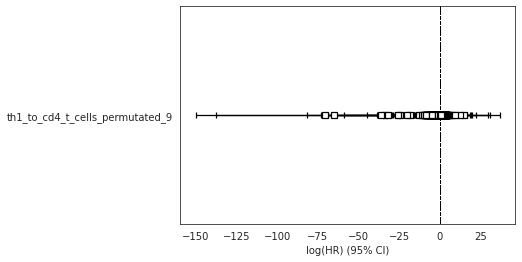

In [54]:
for cel in fc.columns.to_list()+populations_united.columns.to_list():
    if cel in populations_united.columns.to_list():
        metric = scale_series(populations_united[cel].dropna())
    else:
        metric = scale_series(fc[cel].dropna())
    coef,p,c, c_low, c_up, name = count_uni_cox(median_scale(metric).clip(-4,4), cel)

    coefs_perm,ps_perm,cs_perm,c_lows,c_ups = [],[],[],[],[]
    if 'High' in name:
        categorized.append(name.replace('_High', ''))
    for a in range(10):
        metric_random = metric
        l_metric = metric_random.to_list()
        random.shuffle(l_metric)
        metric_random = pd.Series(index=metric_random.index, data=l_metric)
        metric_random.name = f"{cel}_permutated_{a}"
        coef_perm,p_perm,c_perm, c_low_perm, c_up_perm, name  = count_uni_cox(metric_random, cel)
        if not coef_perm is np.nan:
            coefs_perm.append(coef_perm)
            ps_perm.append(p_perm)
            cs_perm.append(c_perm)
            c_lows.append(c_low_perm)
            c_ups.append(c_up_perm)
    
    metrics[cel] = {'Coefficient':coef,'P-value':p,'C-index':c,'C_low':c_low,'C_up':c_up,
                   'Coefficient_permutated_mean':np.mean([i for i in coefs_perm if i is not np.nan]),'Coefficient_permutated_std':np.std([i for i in coefs_perm if i is not np.nan]),
                    'P-value_permutated_mean':np.mean([i for i in ps_perm if i is not np.nan]),'P-value_permutated_std':np.std([i for i in ps_perm if i is not np.nan]),
                     'C-index_permutated_mean':np.mean([i for i in cs_perm if i is not np.nan]),'C-index_permutated_std':np.std([i for i in cs_perm if i is not np.nan]),
                     'C_low_permutated_mean':np.mean([i for i in c_lows if i is not np.nan]),'C_low_permutated_std':np.std([i for i in c_lows if i is not np.nan]),
                     'C_up_index_permutated_mean':np.mean([i for i in c_ups if i is not np.nan]),'C_up_permutated_std':np.std([i for i in c_ups if i is not np.nan])}

In [59]:
metrics = pd.DataFrame(metrics)
metrics = metrics.T
metrics = metrics.dropna()
_,metrics['FDR'],_,_ = multipletests(metrics['P-value'],method='fdr_bh')

In [60]:
metrics['Better_than_permuted'] = metrics['C-index_permutated_mean']<metrics['C-index']
metrics.to_csv('Time_to_event_results/iterative_univariate_cph_results.tsv',sep='\t')

In [61]:
labels = []
c = 0
for a, i in enumerate(metrics['C-index'][metrics['Better_than_permuted']].sort_values(ascending=False).index):
    if metrics['P-value'].loc[i]<=0.1:
        c+=1
        labels.append(i)
        print(i, metrics['P-value'].loc[i], metrics['C-index'].loc[i])
        labels.append(f"{i}, permutated")
        
x = metrics['Coefficient_permutated_mean'] + metrics['Coefficient_permutated_std']
x.index = x.index.map(lambda x:f"{x}, permutated")
upper_bounds = pd.concat([metrics.C_up, x]).loc[labels]

x = metrics['Coefficient_permutated_mean'] - metrics['Coefficient_permutated_std']
x.index = x.index.map(lambda x:f"{x}, permutated")
lower_bounds = pd.concat([metrics.C_low, x]).loc[labels]

x = metrics['Coefficient_permutated_mean'].copy()
x.index = x.index.map(lambda x:f"{x}, permutated")
means = pd.concat([metrics.Coefficient, x]).loc[labels]

fdr = metrics[metrics['Better_than_permuted']]['P-value'].loc[[i for i in labels if 'permutated' not in i]]

_,a,_,_ = multipletests(fdr, method='fdr_bh')

fdr = pd.Series(data=a, index=fdr.index)
fdr.loc[[i for i in labels if 'permutated' not in i]]

Th1 CM maturity and None expression 0.0796066759391351 0.5986159169550173
CD8+ TE maturity and None expression 0.0886926599046483 0.5928489042675894
CD4+ TE maturity and PD-1-TIGIT+ expression 0.0562958750145165 0.5928489042675894
cd4_t_cells 0.0443980734882189 0.5767012687427913
cd4_to_cd8_t_cells 0.0285798360715825 0.5743944636678201
cd8_t_cells 0.045903265035224 0.5743944636678201
active_t_cells 0.0990126162826771 0.5709342560553633
Th2 CM maturity and None expression 0.0840065099542798 0.5570934256055363


Th1 CM maturity and None expression            0.099013
CD8+ TE maturity and None expression           0.099013
CD4+ TE maturity and PD-1-TIGIT+ expression    0.099013
cd4_t_cells                                    0.099013
cd4_to_cd8_t_cells                             0.099013
cd8_t_cells                                    0.099013
active_t_cells                                 0.099013
Th2 CM maturity and None expression            0.099013
dtype: object

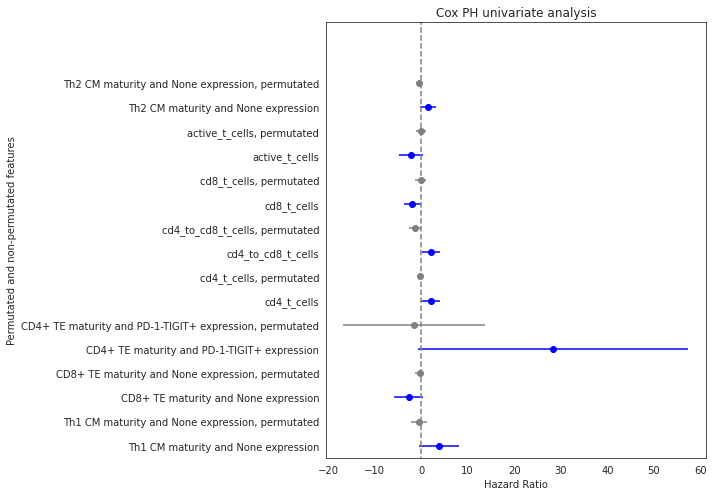

<Figure size 432x288 with 0 Axes>

In [62]:
def forest_plot(means, lower_bounds, upper_bounds, labels, colors=None):
    y_positions = range(len(means))
    plt.figure(figsize=(10, 7))
    if colors is None:
        colors = ['black'] * len(means)
    for mean, low, up, y, color in zip(means, lower_bounds, upper_bounds, y_positions, colors):
        plt.scatter(mean, y, color=color, zorder=2)
        plt.hlines(y, low, up, color=color, zorder=1)
    plt.yticks(y_positions, labels)
    plt.xlabel('Hazard Ratio')
    plt.ylabel('Permutated and non-permutated features')
    plt.title('Cox PH univariate analysis')
    plt.vlines(0, colors='gray', ymin=-1, ymax=17.5, linestyles='dashed')
    plt.ylim(-0.5,17.5)
    plt.tight_layout()
    plt.show()

forest_plot(means, lower_bounds, upper_bounds, labels,colors = ['blue' if 'permutated' not in i else 'gray' for i in labels])
plt.savefig('forest_plot')

In [19]:
kmf = KaplanMeierFitter()

In [ ]:
kmf.fit(durations, events)